In [1]:
import numpy as np
from scipy import linalg
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.collections
import matplotlib.patches
import pg_fitter_tools as fit
import sk_geo_tools as geo
import cv2
import re
from collections import Counter

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [21]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
focal_length = [2.760529621789217e+03, 2.767014510543478e+03]
principle_point = [1.914303537872458e+03, 1.596386868474348e+03]
radial_distortion = [-0.2398, 0.1145]
tangential_distortion = [0, 0]
camera_matrix = fit.build_camera_matrix(focal_length, principle_point)
distortion = fit.build_distortion_array(radial_distortion, tangential_distortion)

In [34]:
camera_r = 1100.
camera_z = 0.
n_cameras = 50
camera_phis = np.array([np.pi*i*2./n_cameras for i in range(n_cameras)])
camera_positions = np.column_stack((
    camera_r*np.sin(camera_phis),
    camera_r*np.cos(camera_phis),
    np.repeat(0, n_cameras)))
camera_directions = np.column_stack((
    np.sin(camera_phis),
    np.cos(camera_phis),
    np.repeat(0., n_cameras)))
camera_rolls = np.repeat(0., n_cameras)
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls, 2)

In [6]:
pmt_locations = fit.read_3d_feature_locations("parameters/SK_all_PMT_locations.txt", delimiter="\t")
# pmt_locations = fit.read_3d_feature_locations("parameters/SK_simtest_PMT_locations.txt", delimiter=" ")
bolt_count = 24
bolt_locations = geo.get_bolt_locations_barrel(pmt_locations, bolt_count)
ring_positions = {k: np.mean([bolt_locations[re.sub(r"-00$", "-" + str(i + 1).zfill(2), k)] for i in range(0, 24, 24//bolt_count)], axis=0)
                           for k in pmt_locations.keys()}

In [7]:
def setup_bolt_simulation(feature_positions, image_feature_locations, focal_length, principle_point, radial_distortion, seed_error=1):
    seed_feature_positions = {}
    for i, f in feature_positions.items():
        seed_feature_positions[i] = np.random.normal(f, seed_error)
    fitter = fit.PhotogrammetryFitter(image_feature_locations, seed_feature_positions, focal_length, principle_point, radial_distortion)
    return fitter

In [8]:
def run_bolt_fit(fitter, bolt_positions, xtol=1e-6):
    reco_cam_rotations, reco_cam_translations, reprojected_points = fitter.estimate_camera_poses()
    reco_cam_rotations, reco_cam_translations, reco_locations = fitter.bundle_adjustment(reco_cam_rotations, reco_cam_translations, xtol=xtol)
    
    reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(bolt_positions, reco_locations)
    print("mean reconstruction error:", linalg.norm(reco_errors, axis=1).mean())
    print("max reconstruction error:", linalg.norm(reco_errors, axis=1).max())

    reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(reco_cam_rotations, reco_cam_translations)
    cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
    cam_positions_translated = reco_cam_positions - translation
    cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

    reco_bolt_positions = reco_positions_dict(reco_transformed, fitter.feature_index)
    position_errors = linalg.norm(reco_errors, axis=1)

    return reco_bolt_positions, position_errors

In [9]:
def reco_positions_dict(reco_positions, feature_index):
    return {f: reco_positions[i] for f, i in feature_index.items()}

In [10]:
def get_full_ring_pmts(bolt_keys, pmt_keys, bolt_count):
    return [p for p in pmt_keys if all(re.sub(r"-00$", "-" + str(i + 1).zfill(2), p) in bolt_keys for i in range(0, 24, 24//bolt_count))]

In [11]:
def get_ring_positions(bolt_positions, pmt_keys, bolt_count):
    return {k: np.mean([bolt_positions[re.sub(r"-00$", "-" + str(i + 1).zfill(2), k)] for i in range(0, 24, 24//bolt_count)], axis=0)
                           for k in pmt_keys}

In [12]:
def get_ring_orientations(bolt_positions, pmt_keys, bolt_count):
    ring_orientations = {}
    for k in pmt_keys:
        c, n = geo.fit_plane(np.array([bolt_positions[re.sub(r"-00$", "-" + str(b + 1).zfill(2), k)] for b in range(0, 24, 24//bolt_count)]))
        # flip normal if it is directed away from tank centre
        if np.dot(n,c) > 0:
            n = -n
        ring_orientations[k] = n
    return ring_orientations

In [13]:
def get_ring_centre_errors(reco_bolt_positions, ring_positions, bolt_count):
    full_ring_pmts = get_full_ring_pmts(reco_bolt_positions.keys(), ring_positions.keys(), bolt_count)
    reco_ring_positions = get_ring_positions(reco_bolt_positions, full_ring_pmts, bolt_count)
    errors = np.array([linalg.norm(reco_ring_positions[k] - ring_positions[k]) for k in full_ring_pmts])
    return errors

In [14]:
def get_ring_orientation_errors(reco_bolt_positions, ring_orientations, bolt_count):
    full_ring_pmts = get_full_ring_pmts(reco_bolt_positions.keys(), ring_positions.keys(), bolt_count)
    reco_orientations = get_ring_orientations(reco_bolt_positions, full_ring_pmts, bolt_count)
    errors = np.array([np.degrees(np.arccos(np.dot(reco_orientations[k], ring_orientations[k]))) for k in full_ring_pmts])
    return errors

In [15]:
def make_fig(title, xlabel, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    fig.tight_layout()
    return fig, ax

In [43]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [44]:
def plot_reconstruction(reco_positions, cam_positions):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(reco_positions[:,0], reco_positions[:,1], reco_positions[:,2], marker='^', label="Bolt", s=1)
    ax.scatter(cam_positions[:,0], cam_positions[:,1], cam_positions[:,2], marker='*', label="Camera", s=60)
    set_axes_equal(ax)
    plt.legend(loc=0)
    fig.tight_layout()

In [17]:
def plot_geometry(bolt_positions, pmt_positions, cam_positions):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter([b[0] for b in bolt_positions.values()], [b[1] for b in bolt_positions.values()], [b[2] for b in bolt_positions.values()], marker='.', label="Bolt", s=1)
    ax.scatter([p[0] for p in pmt_positions.values()], [p[1] for p in pmt_positions.values()], [p[2] for p in pmt_positions.values()], marker='o', label="PMT", s=20)
    ax.scatter(cam_positions[:,0], cam_positions[:,1], cam_positions[:,2], marker='^', label="Camera", s=60)
    ax.set_xlabel("x [cm]")
    ax.set_ylabel("y [cm]")
    ax.set_zlabel("z [cm]")
    plt.legend(loc=0)
    fig.tight_layout()

# Simulation with 12 bolts

Feature in image counts: Counter({4: 15120, 5: 1724, 3: 406})


<IPython.core.display.Javascript object>


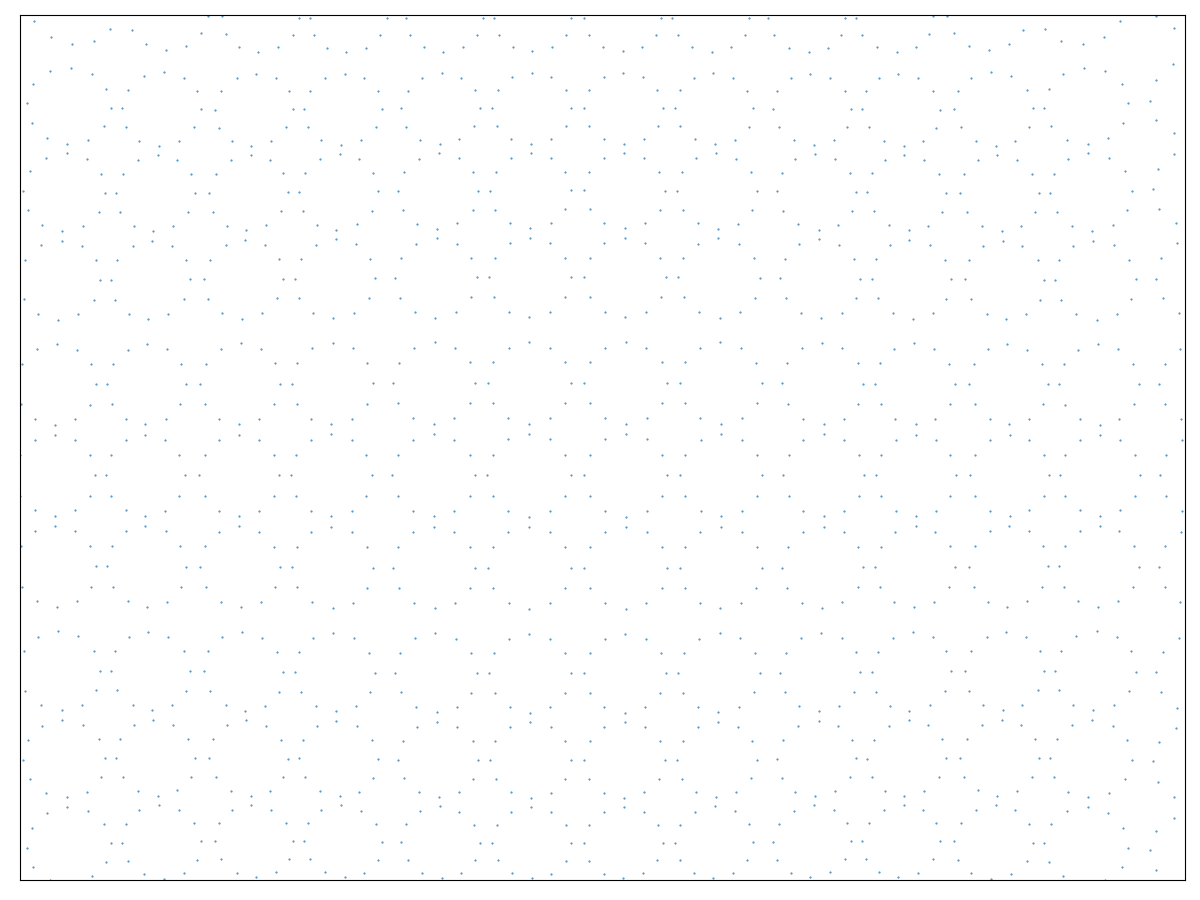

<IPython.core.display.Javascript object>


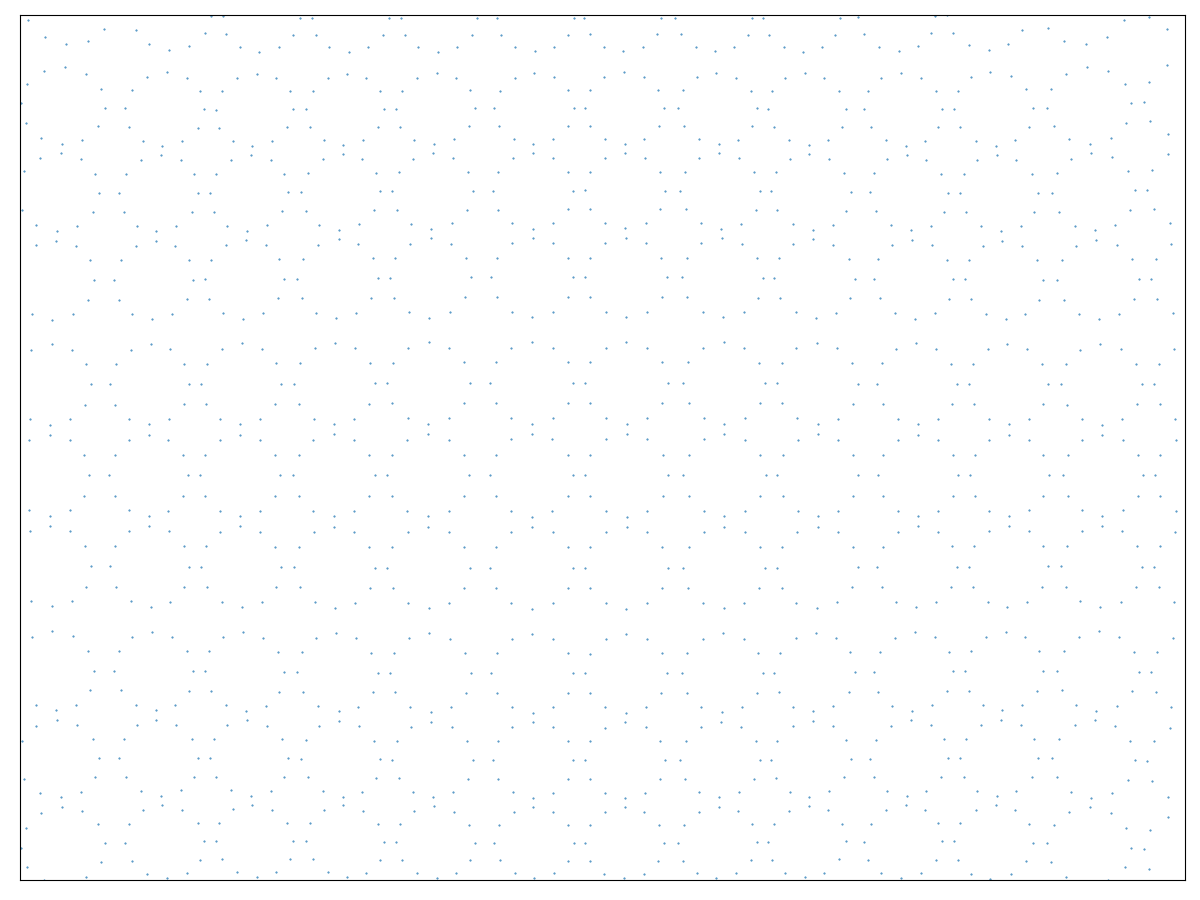

<IPython.core.display.Javascript object>


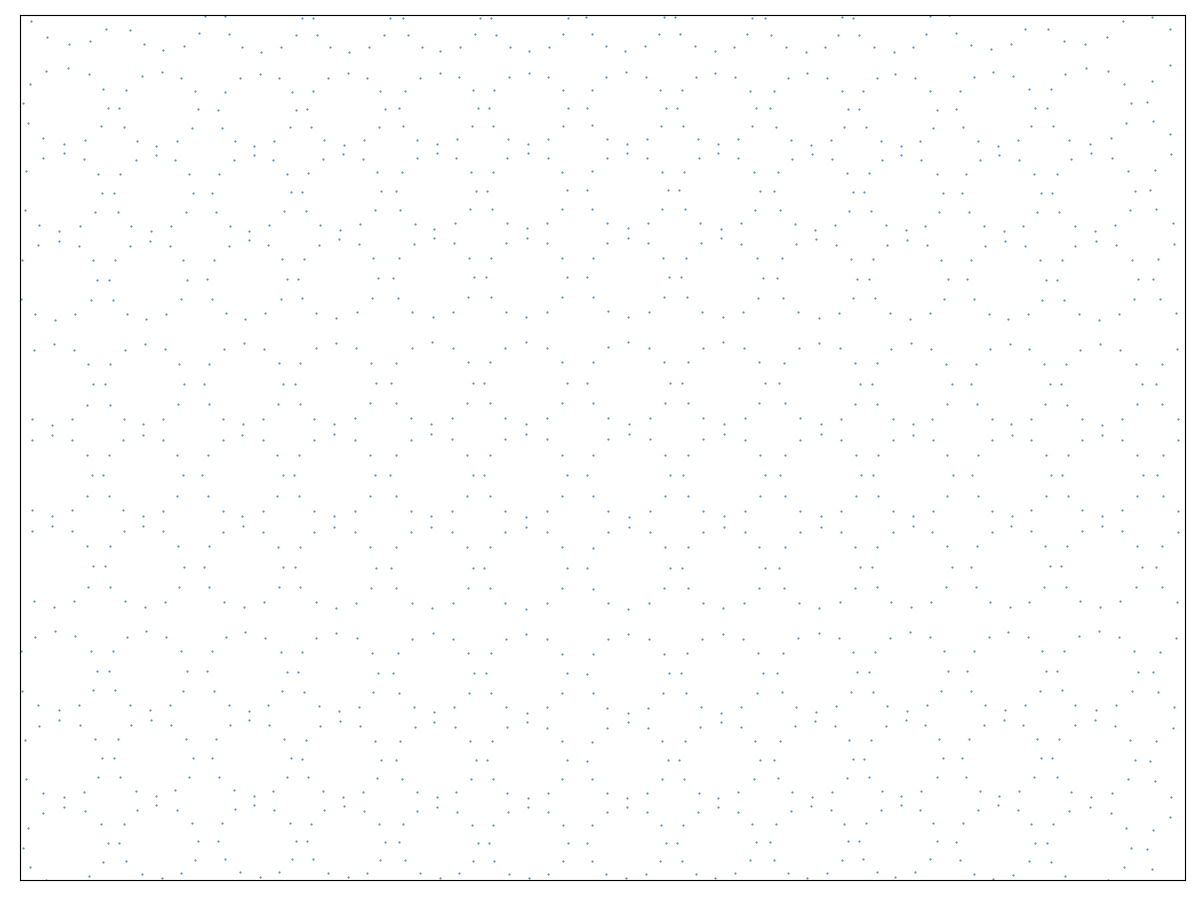

<IPython.core.display.Javascript object>


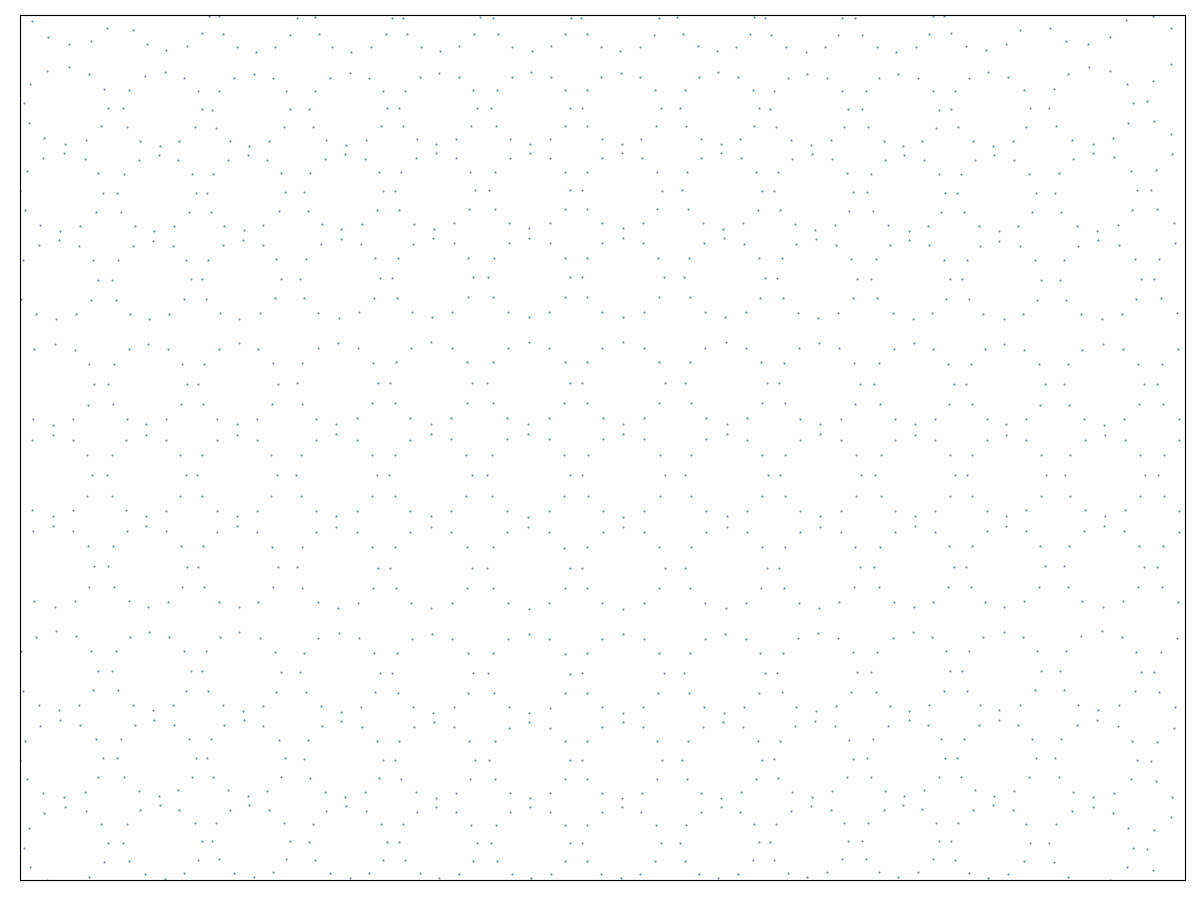

<IPython.core.display.Javascript object>


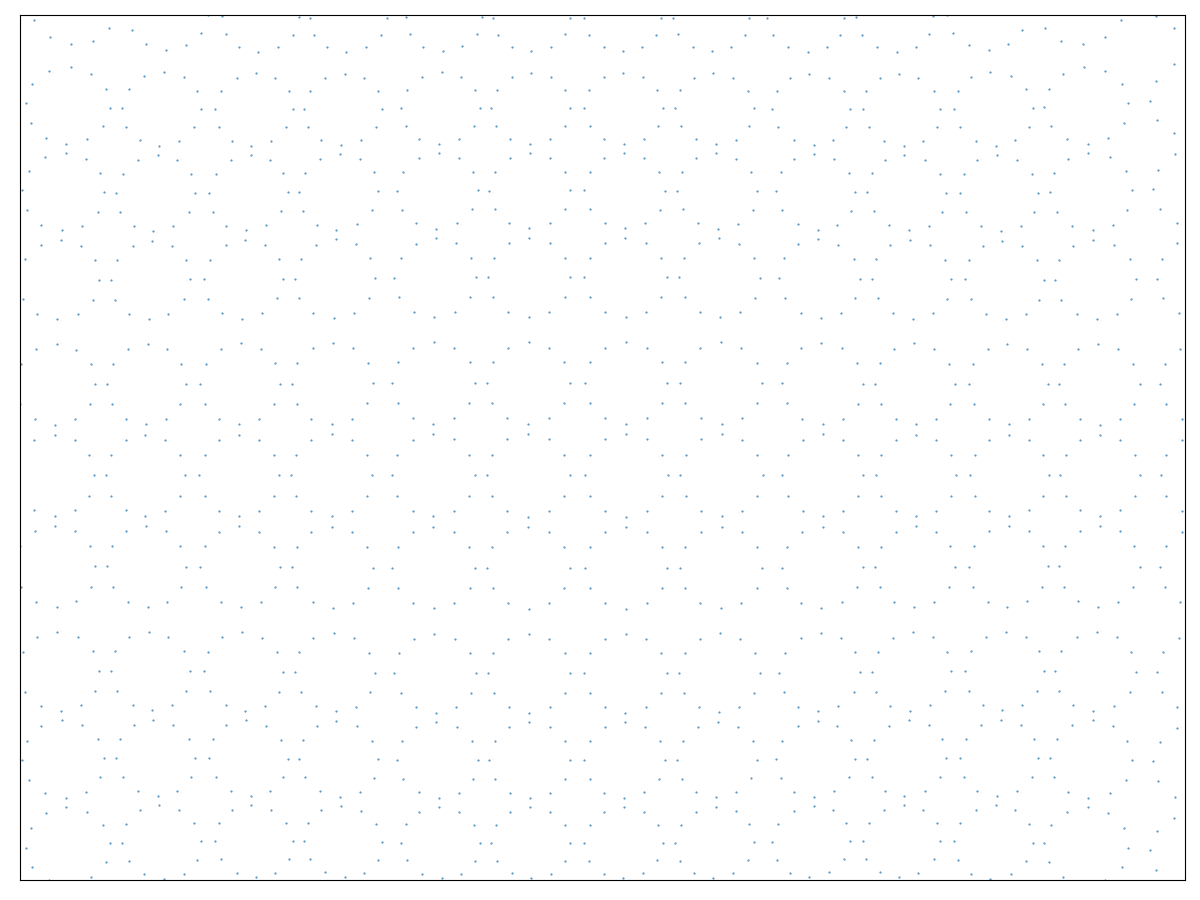

<IPython.core.display.Javascript object>


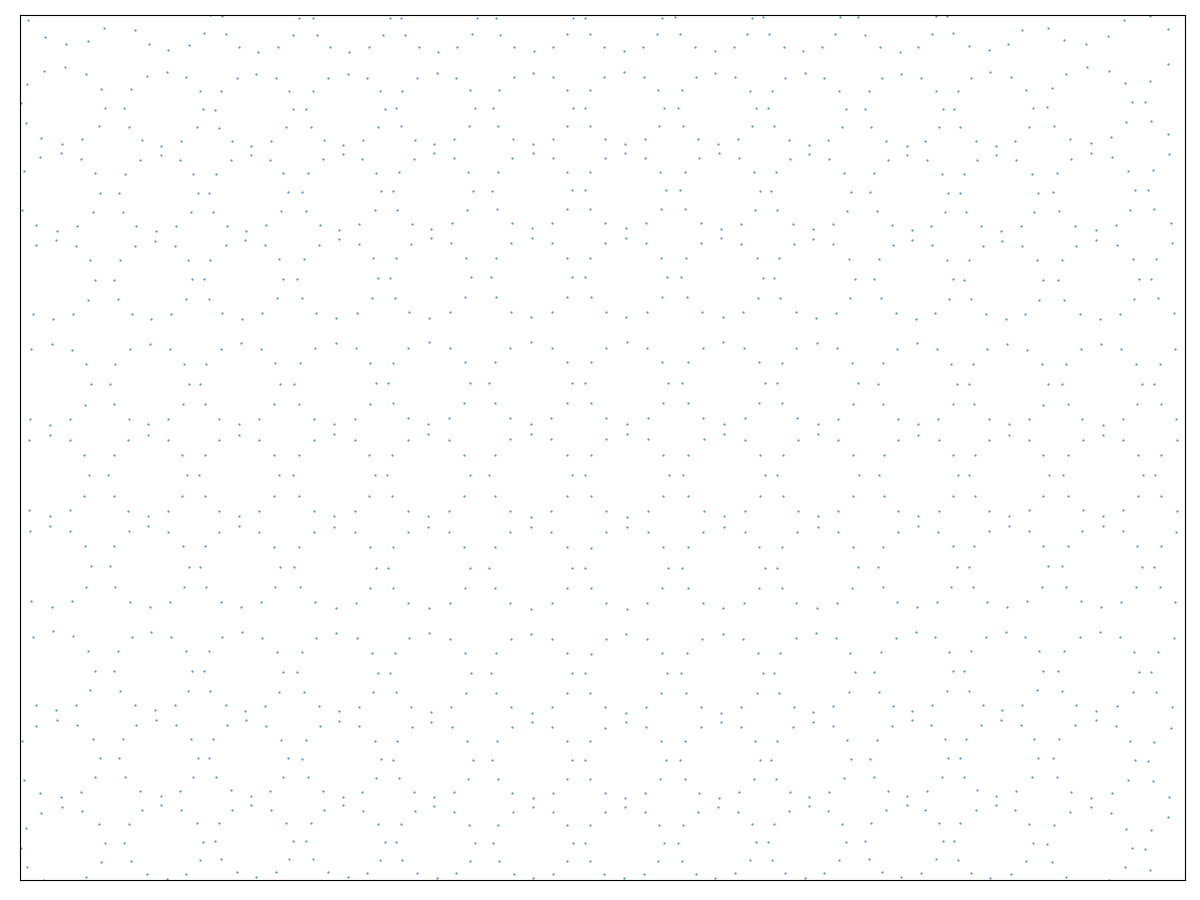

<IPython.core.display.Javascript object>


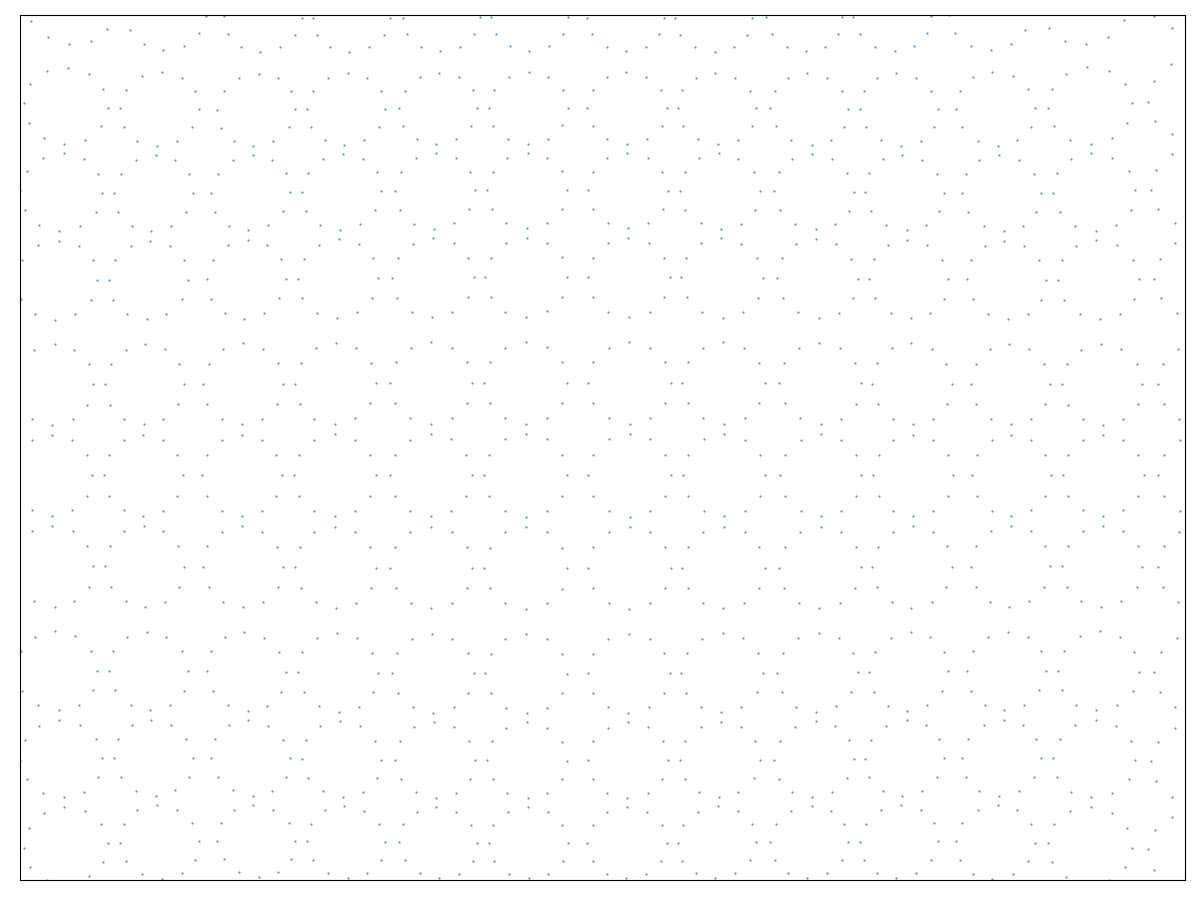

<IPython.core.display.Javascript object>


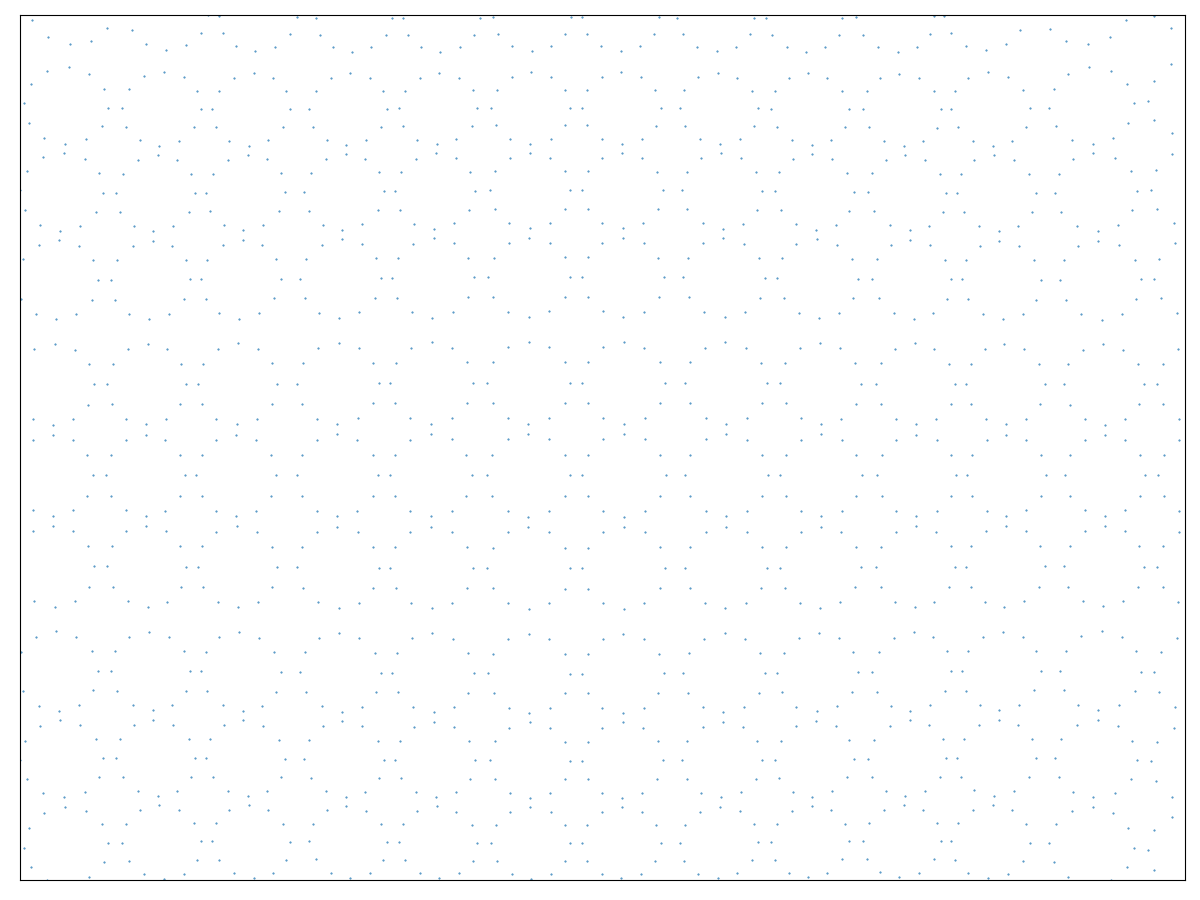

<IPython.core.display.Javascript object>


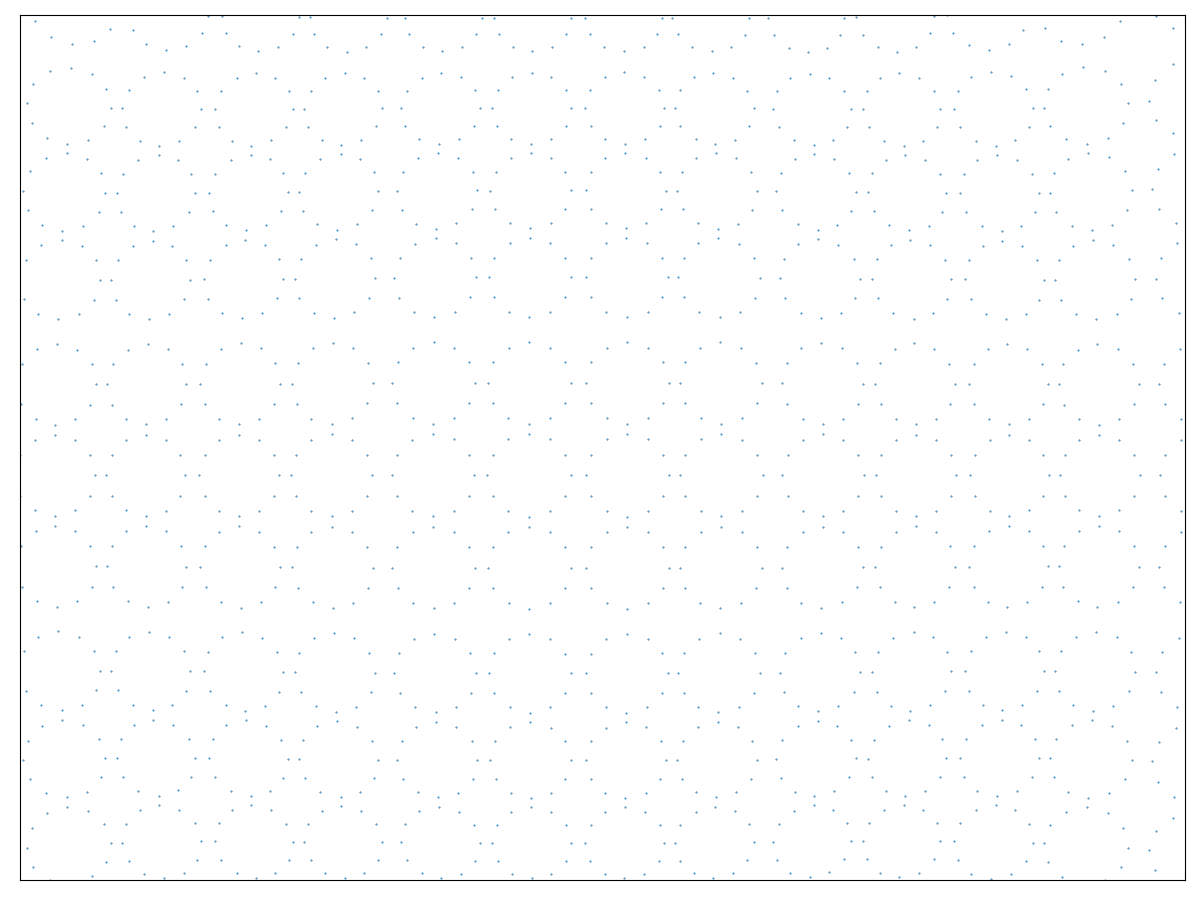

<IPython.core.display.Javascript object>


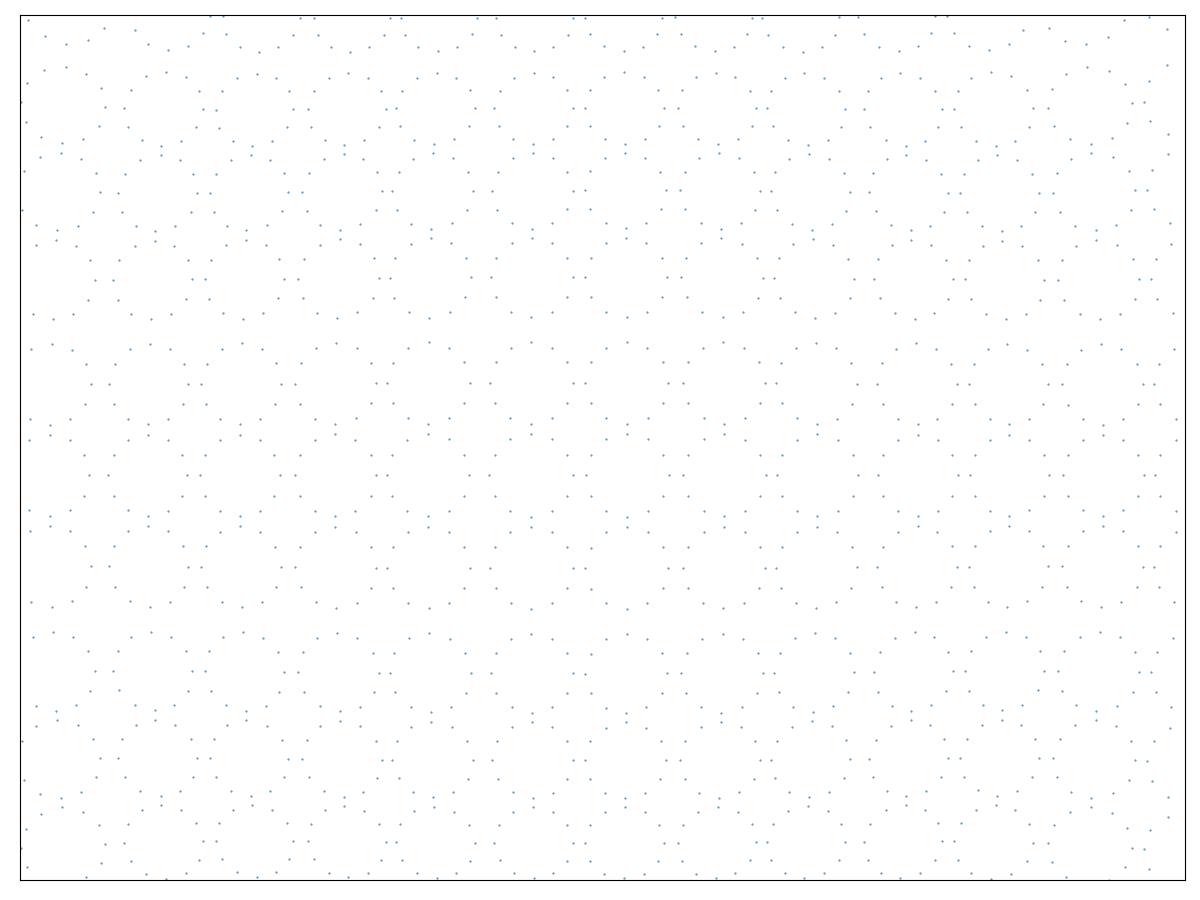

<IPython.core.display.Javascript object>


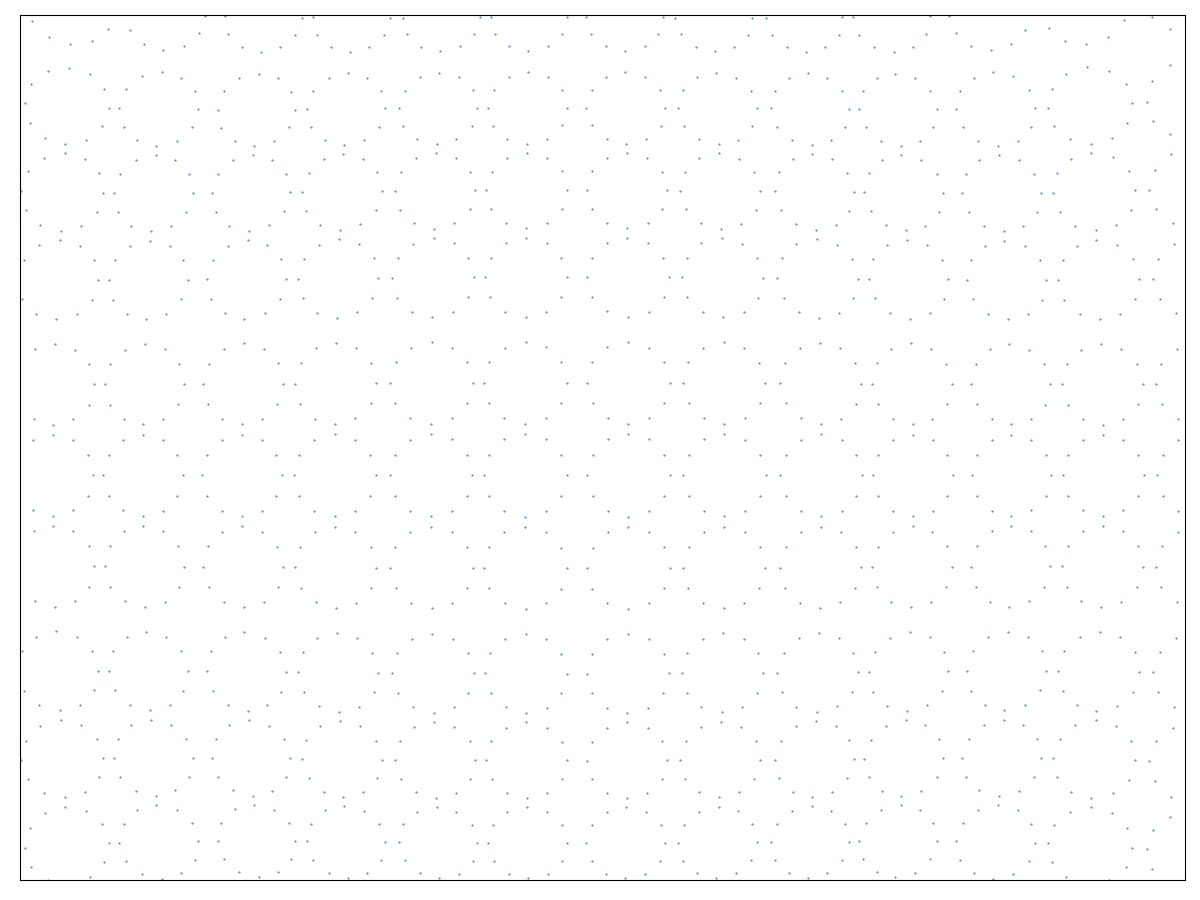

<IPython.core.display.Javascript object>


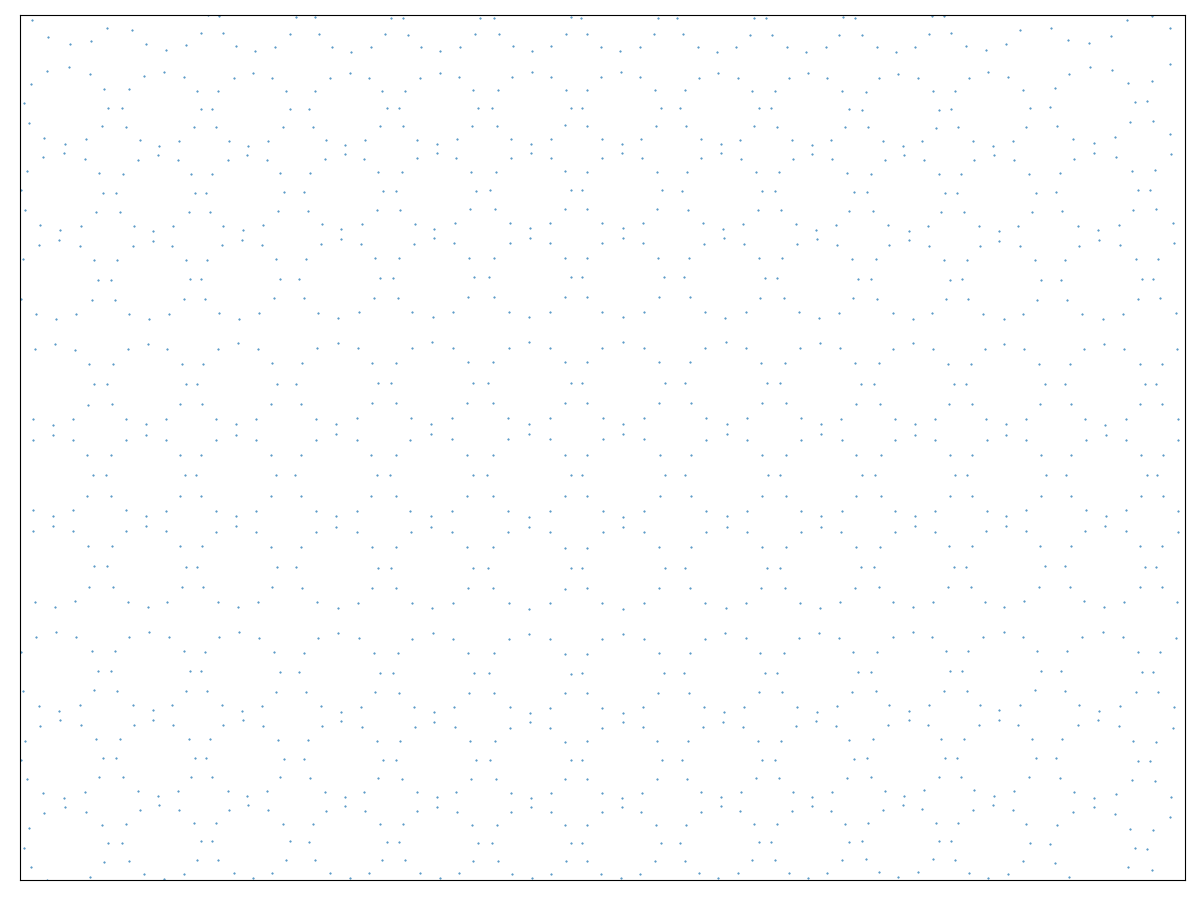

<IPython.core.display.Javascript object>


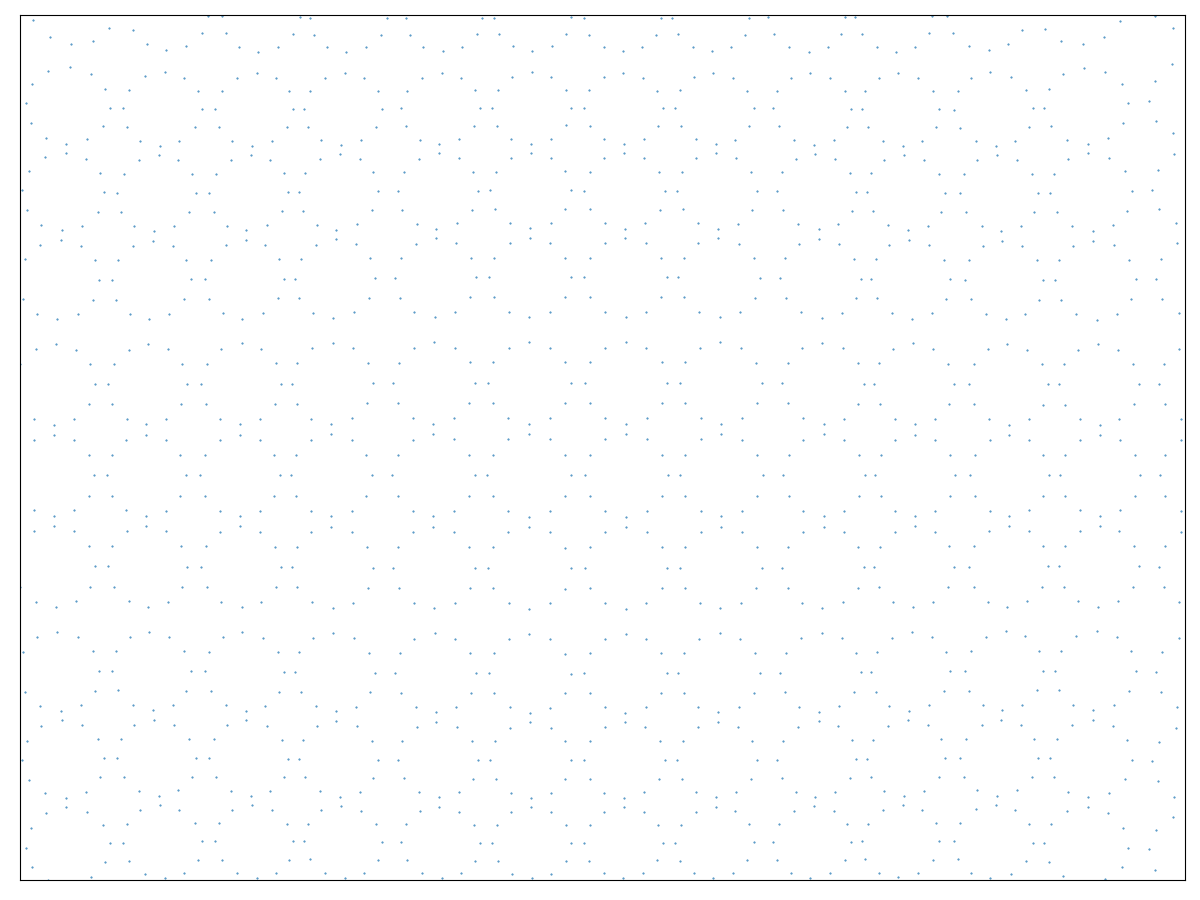

<IPython.core.display.Javascript object>


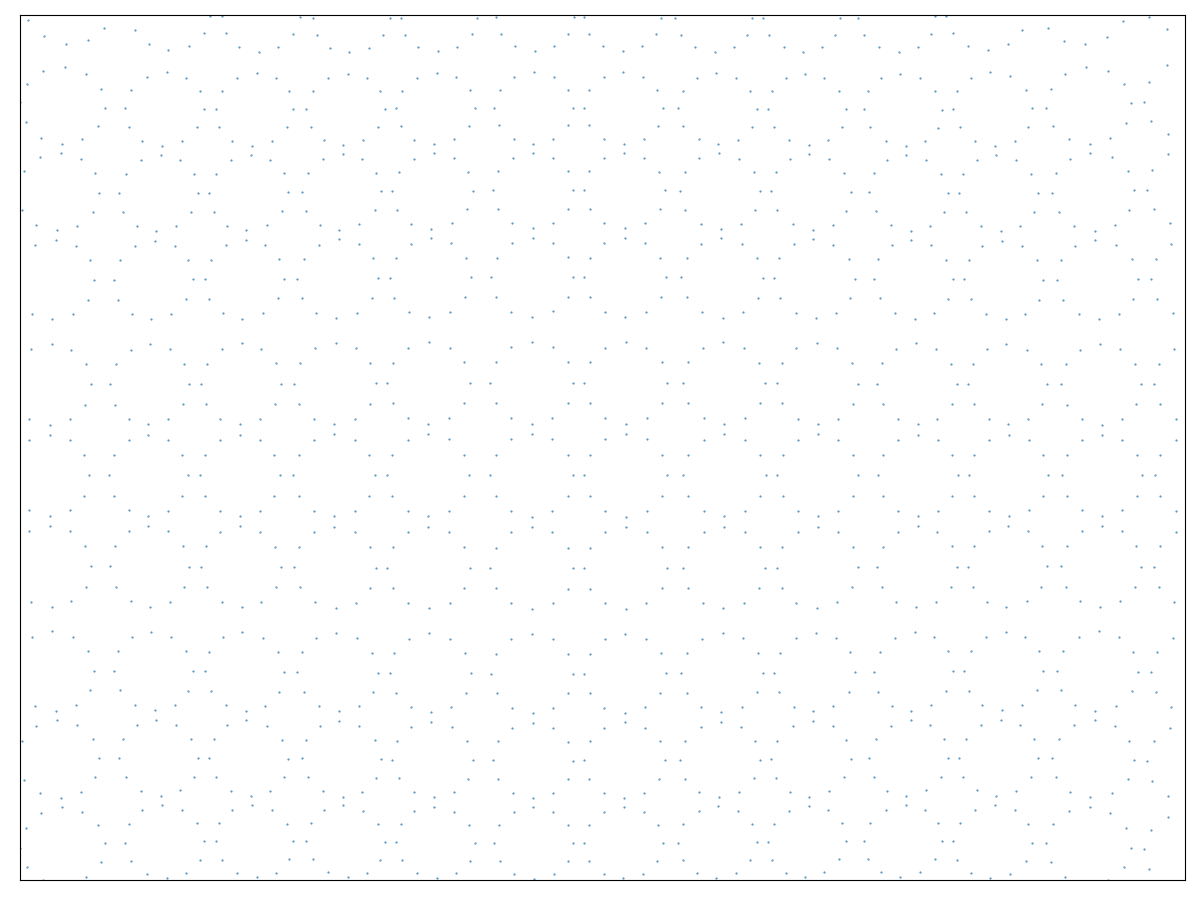

<IPython.core.display.Javascript object>


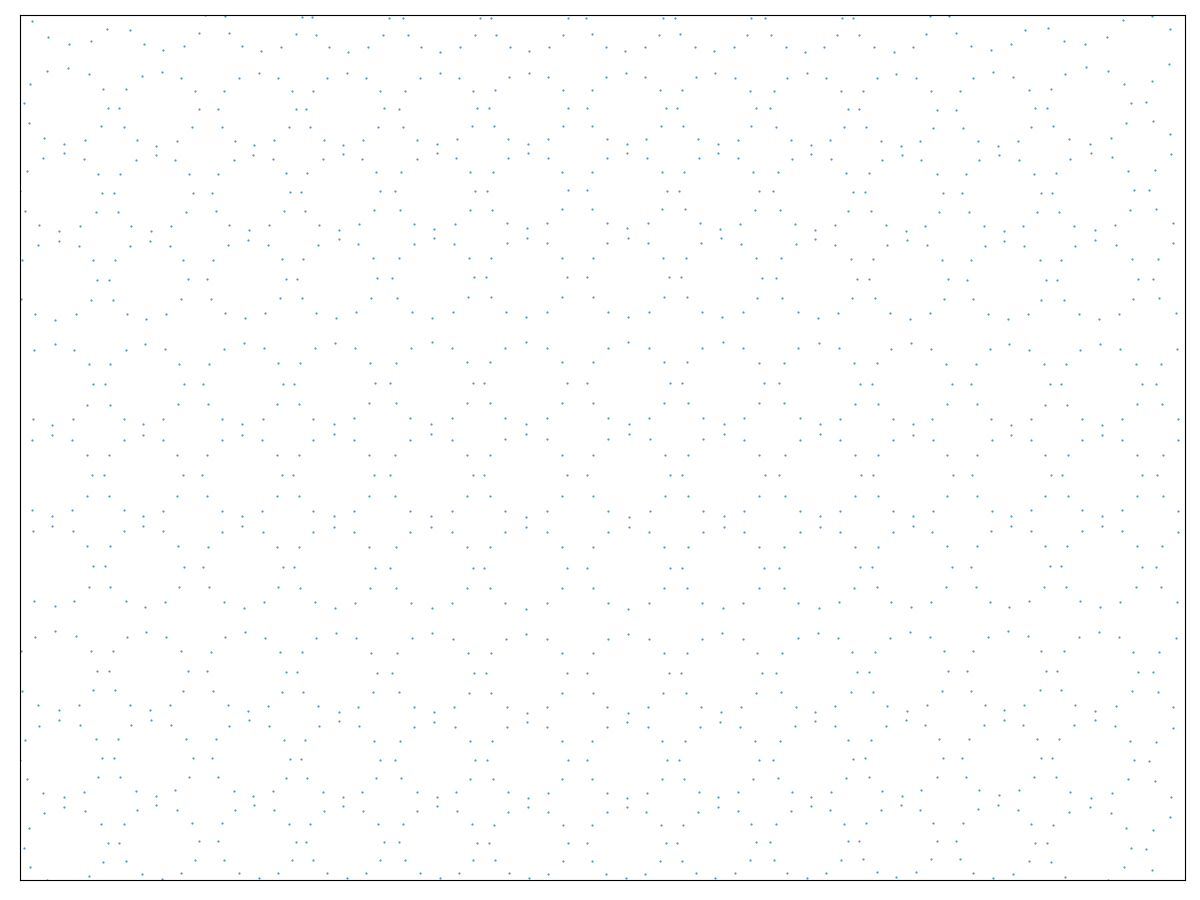

<IPython.core.display.Javascript object>


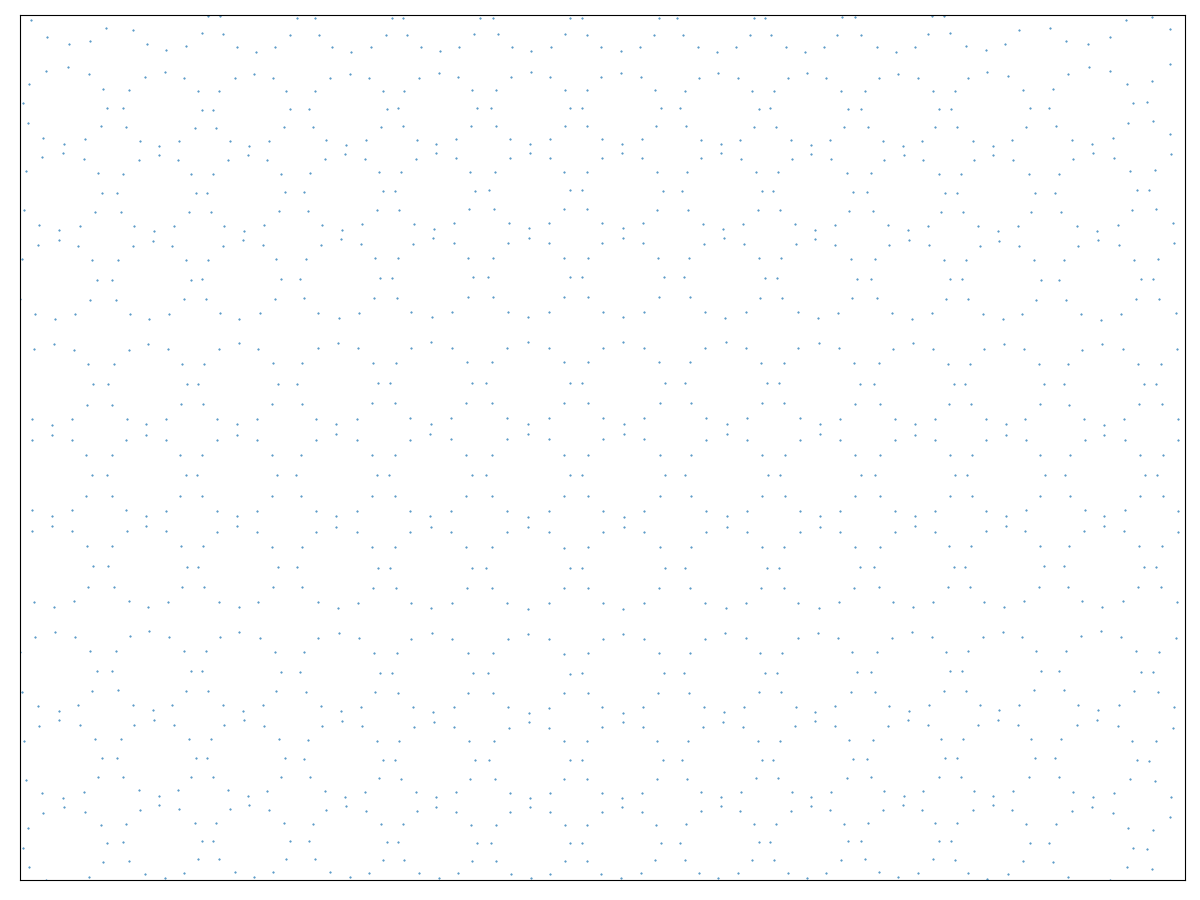

<IPython.core.display.Javascript object>


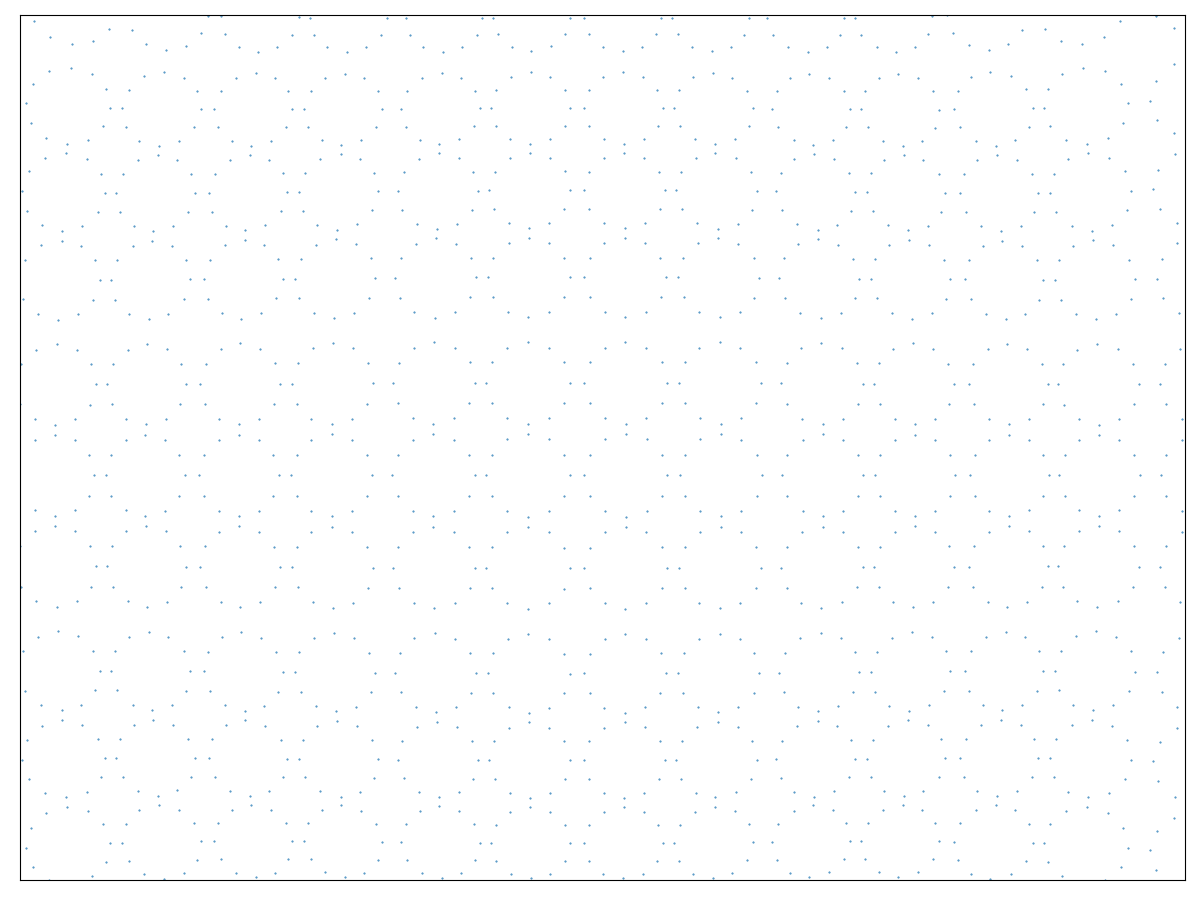

<IPython.core.display.Javascript object>


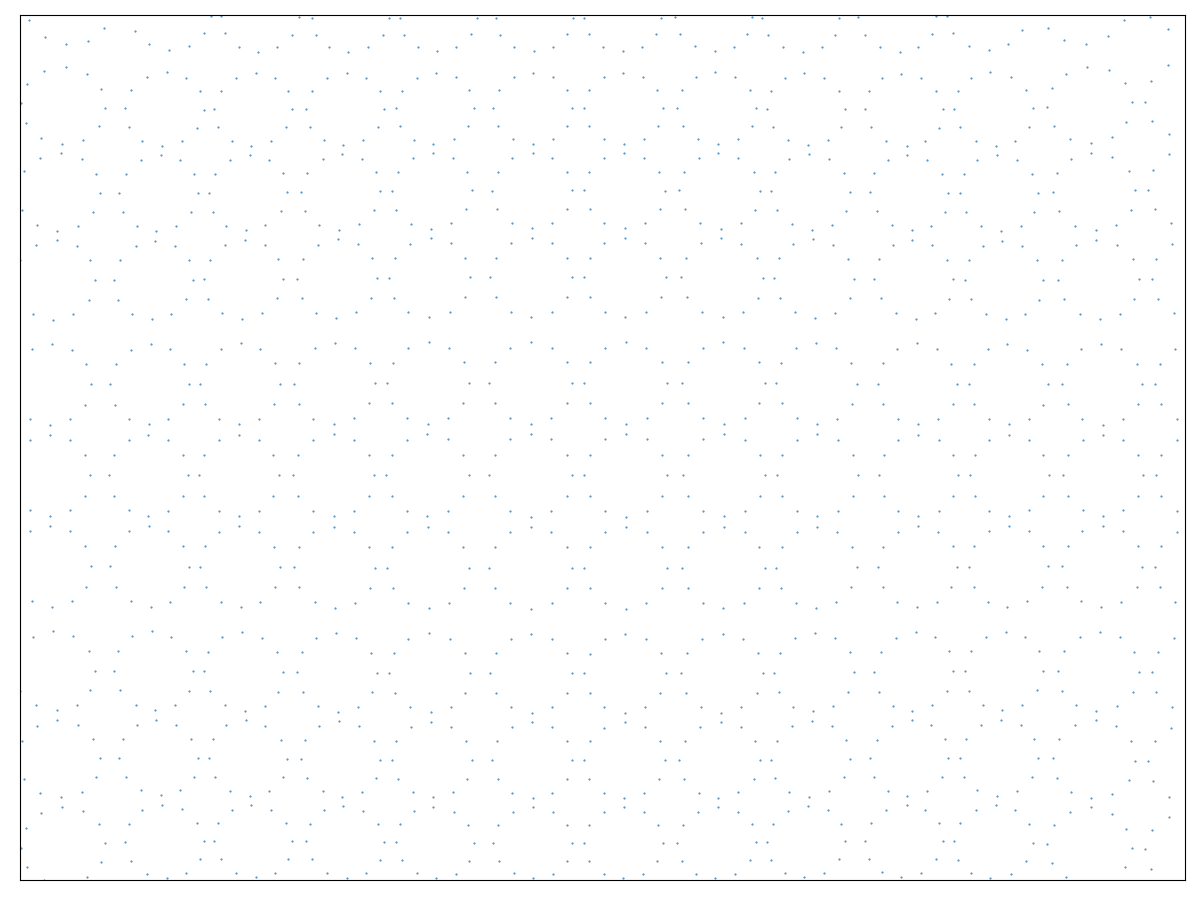

<IPython.core.display.Javascript object>


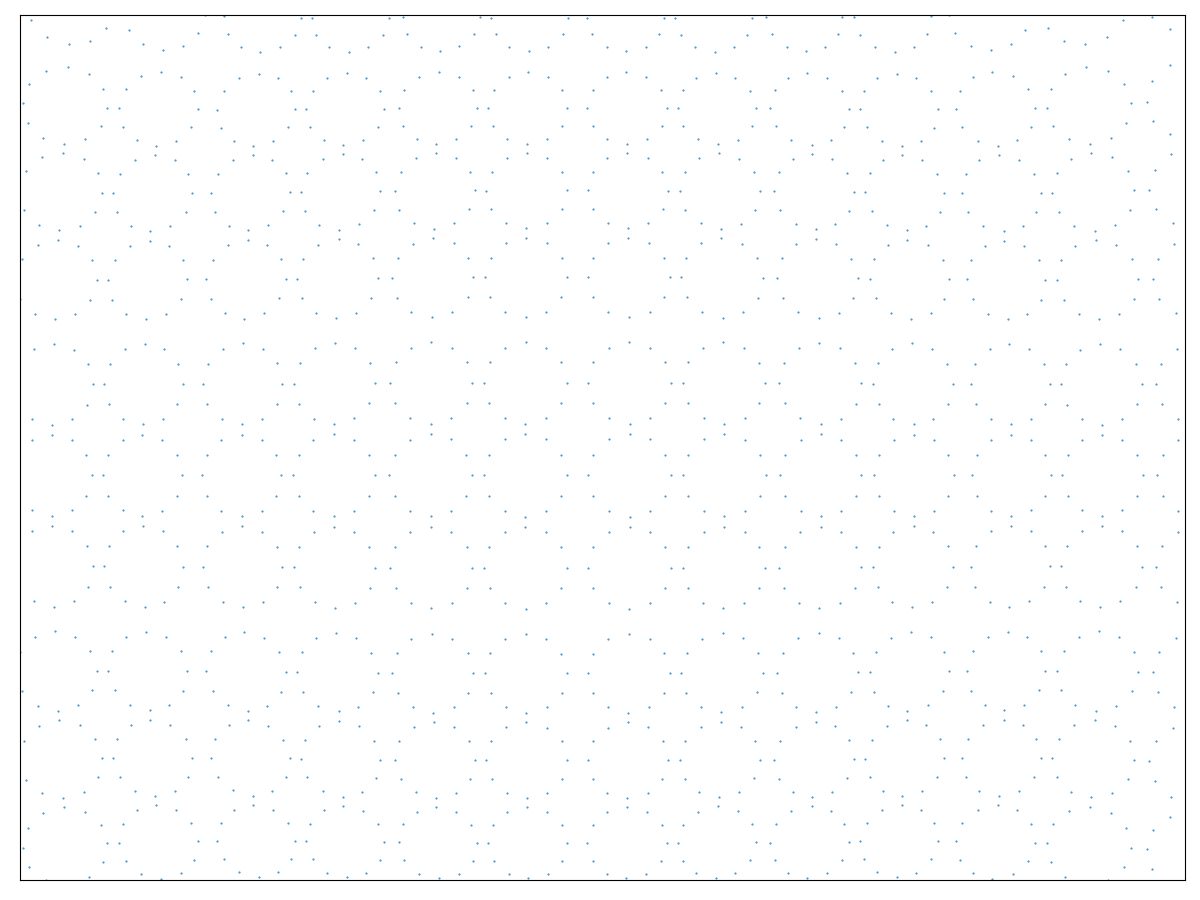

<IPython.core.display.Javascript object>


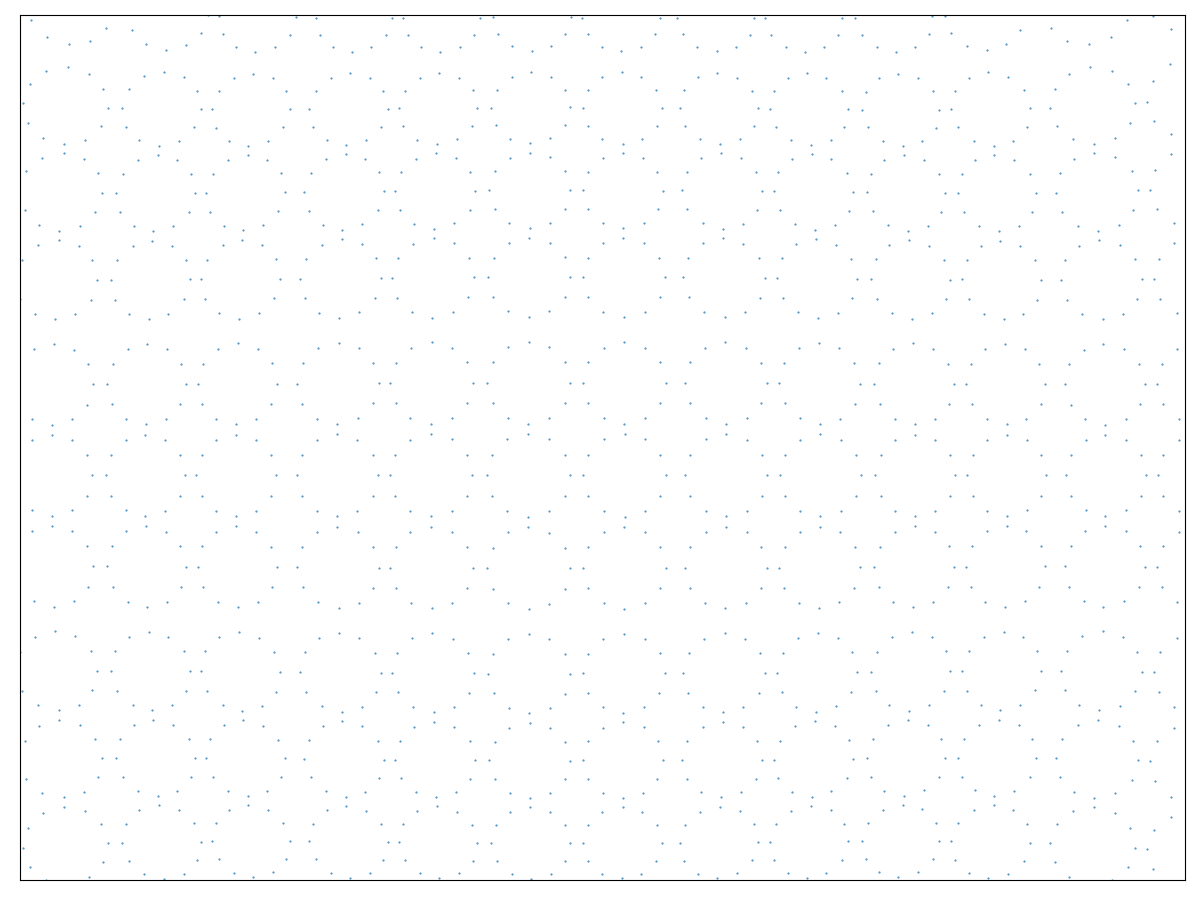

<IPython.core.display.Javascript object>


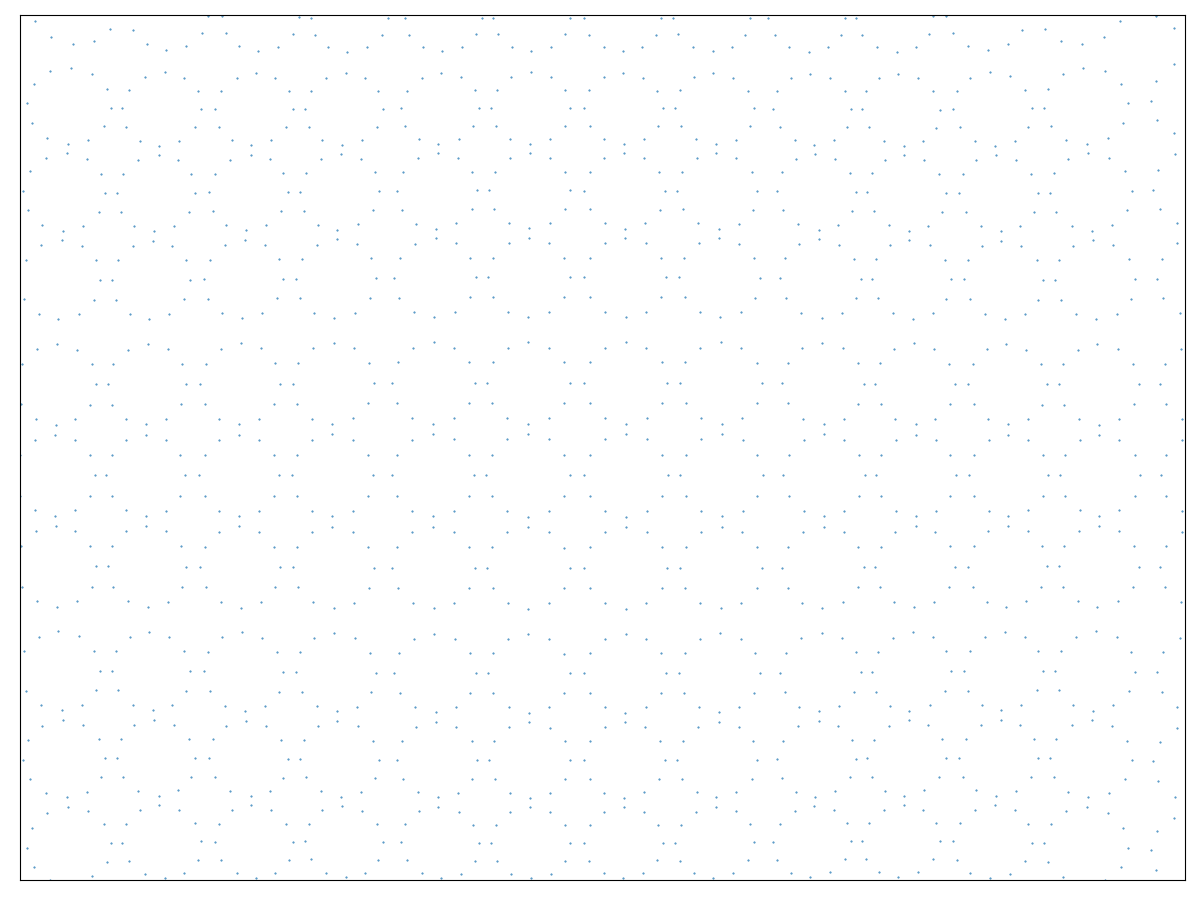

<IPython.core.display.Javascript object>


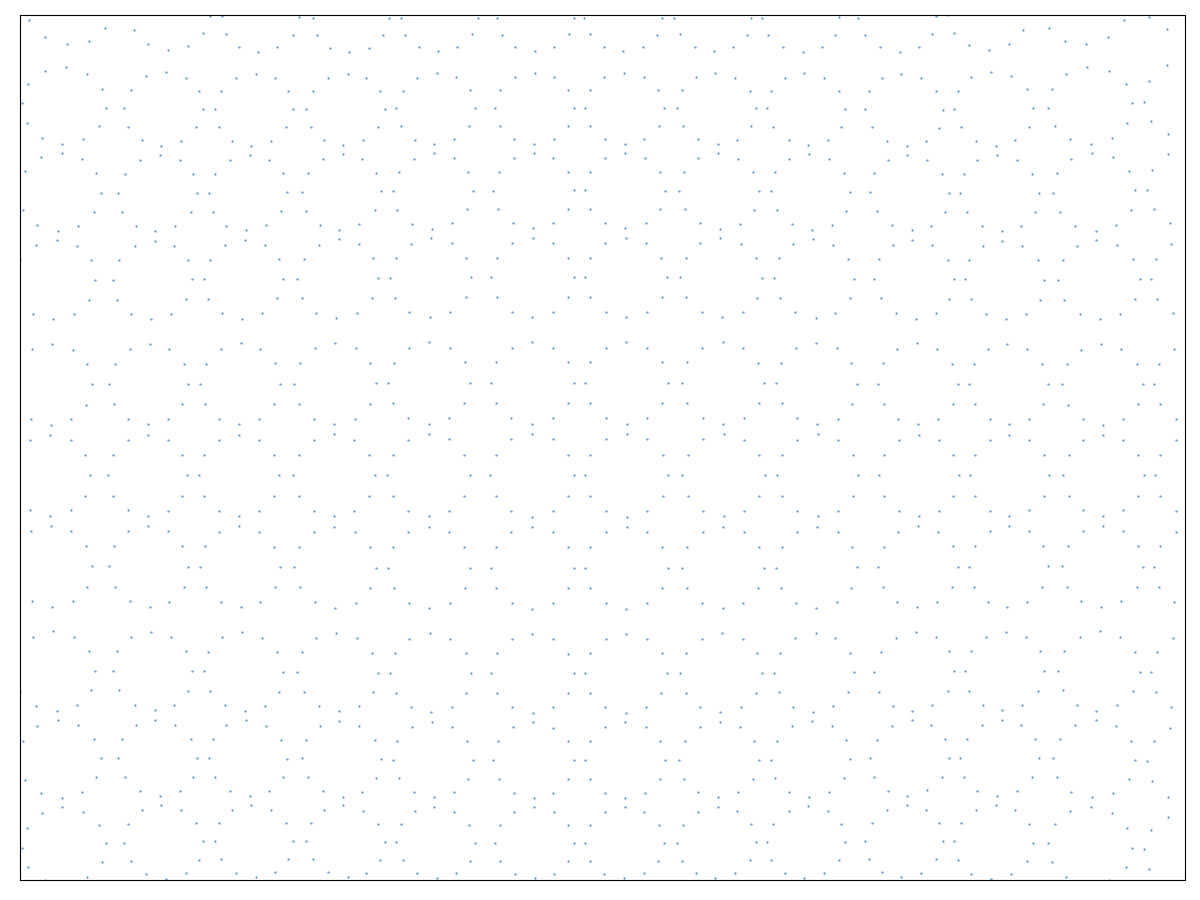

<IPython.core.display.Javascript object>


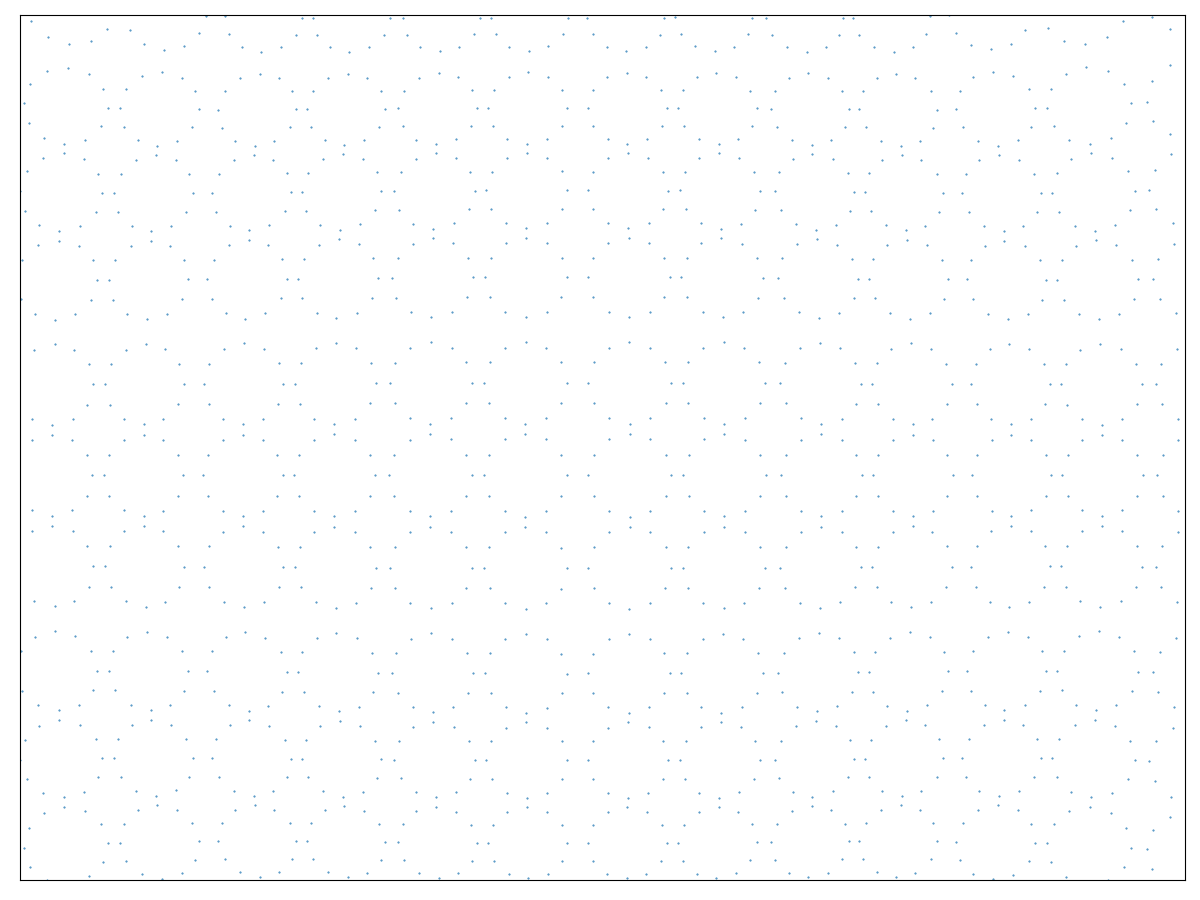

<IPython.core.display.Javascript object>


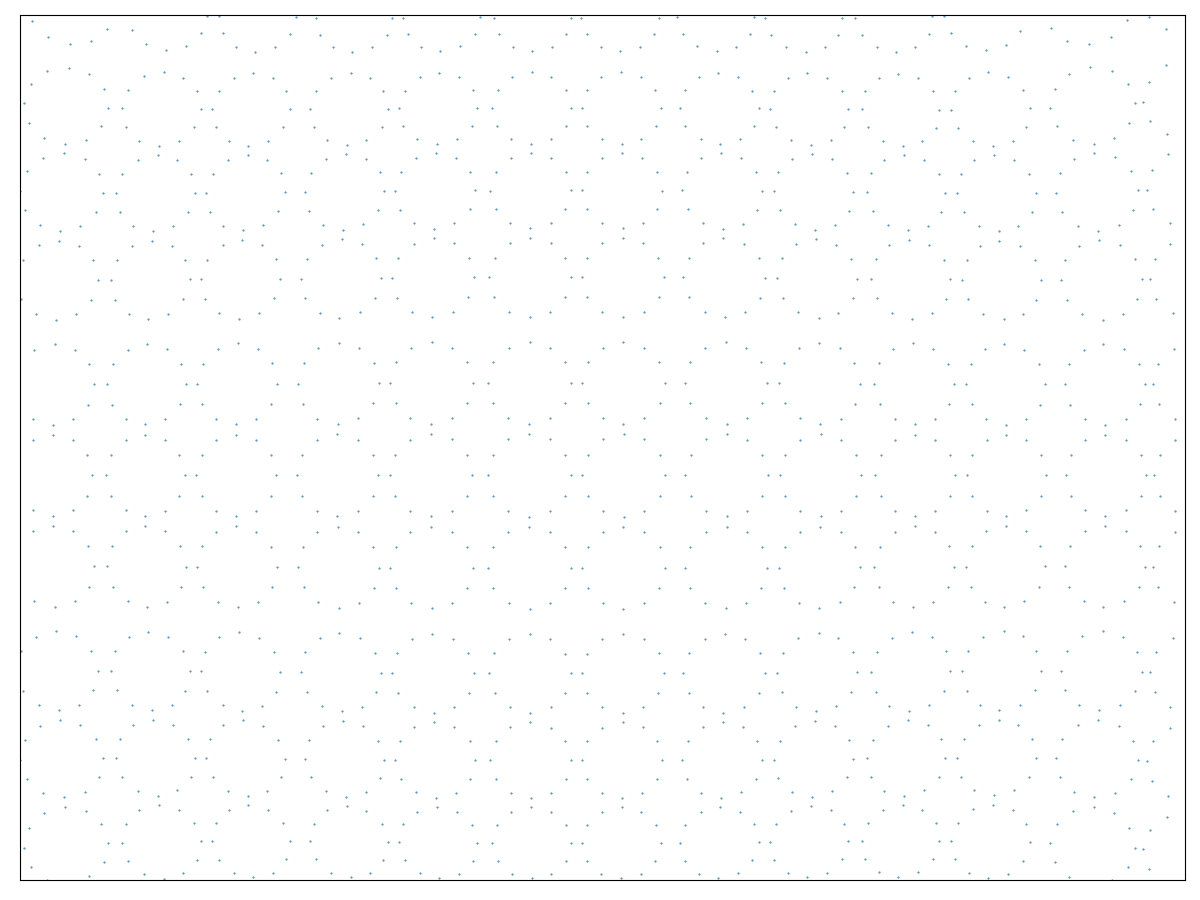

<IPython.core.display.Javascript object>


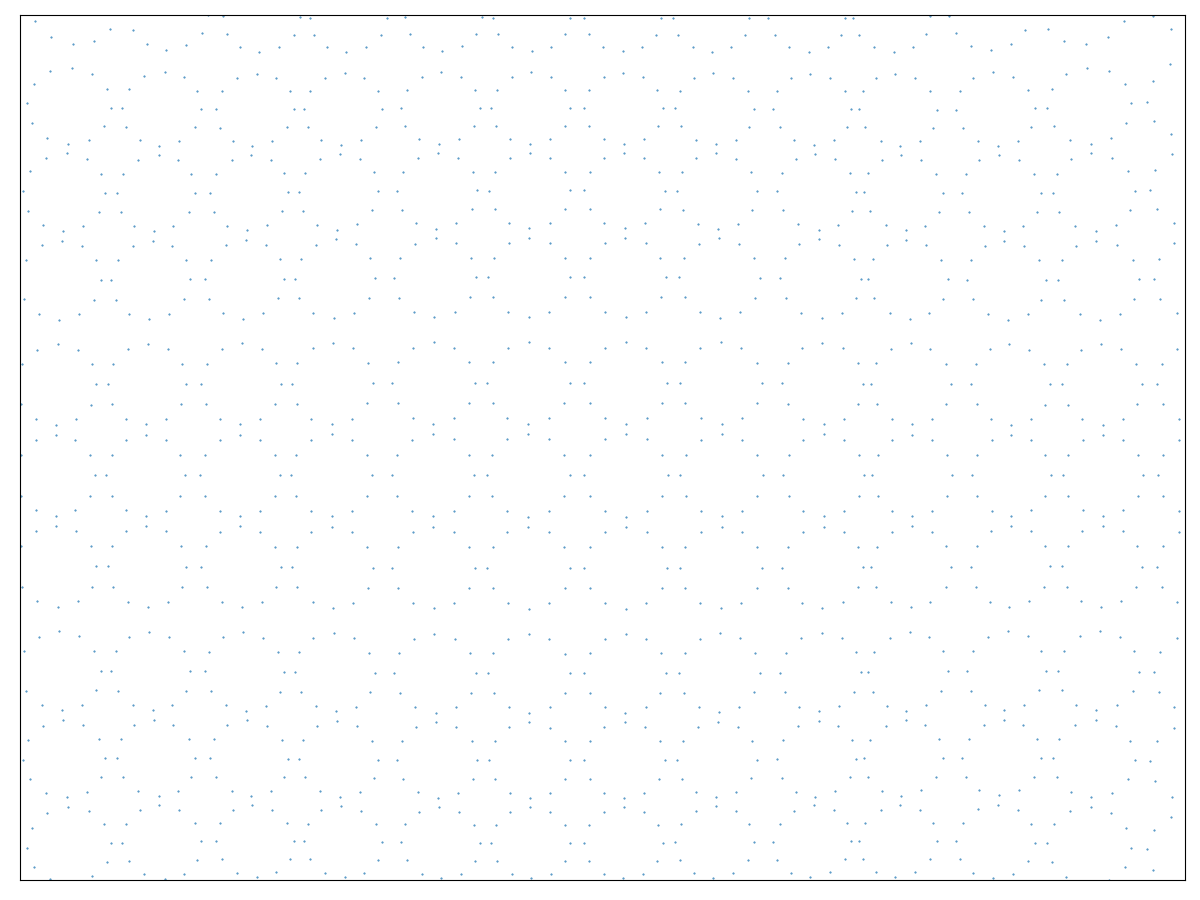

<IPython.core.display.Javascript object>


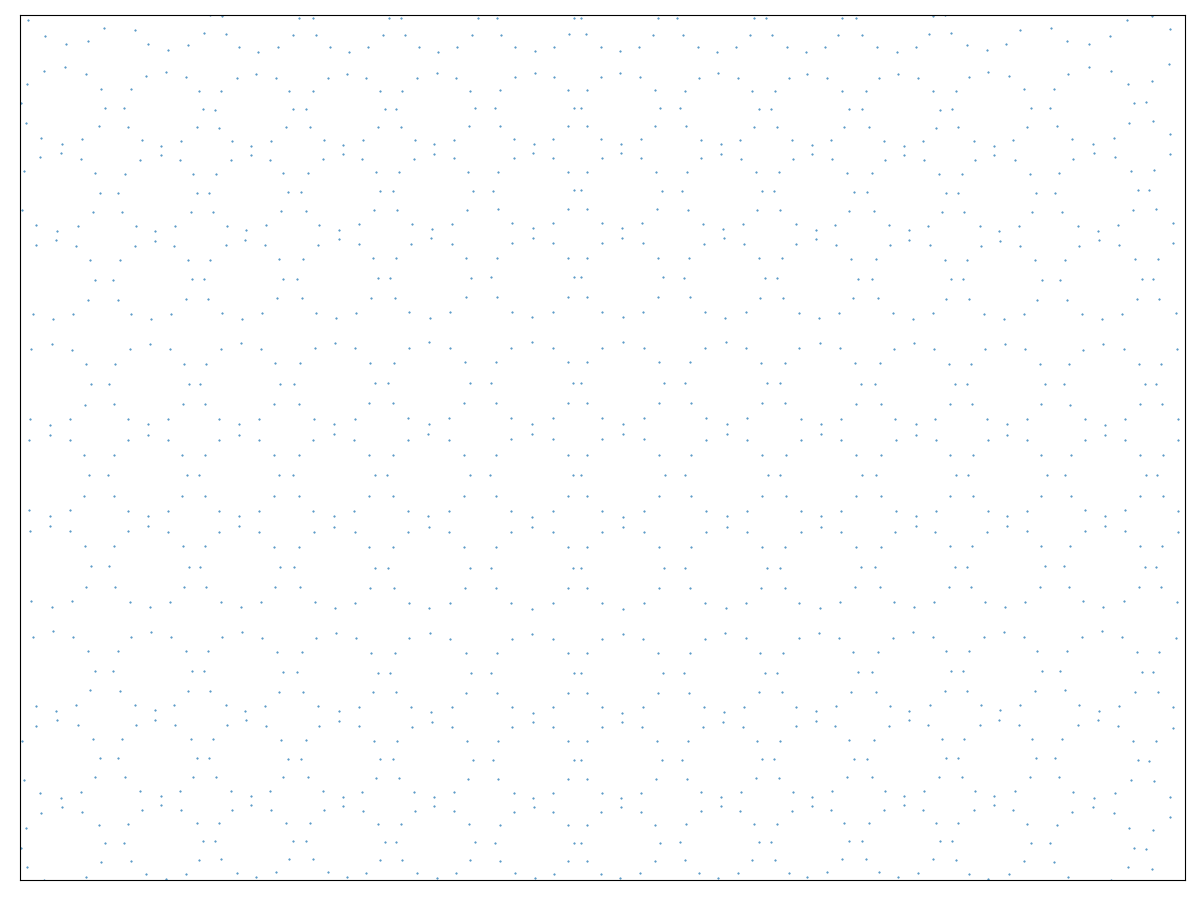

<IPython.core.display.Javascript object>


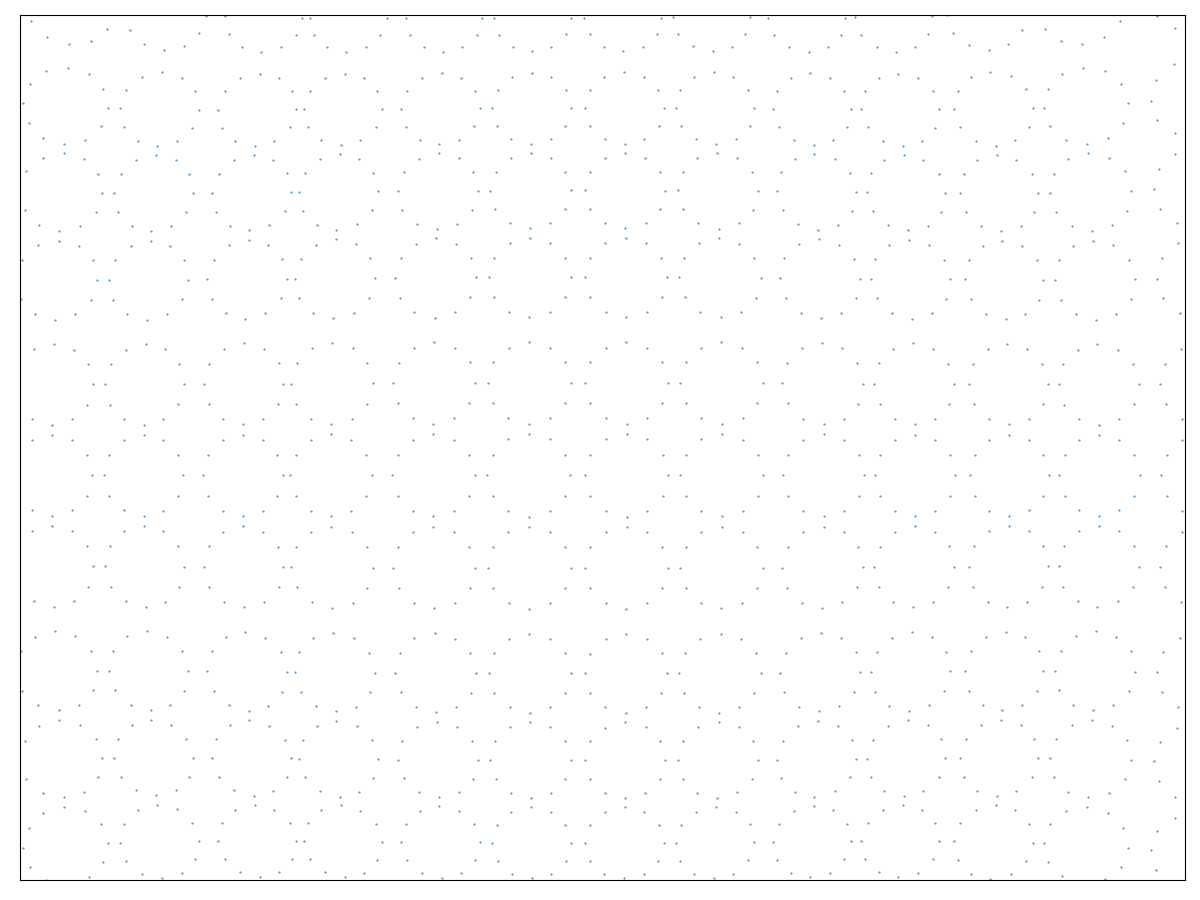

<IPython.core.display.Javascript object>


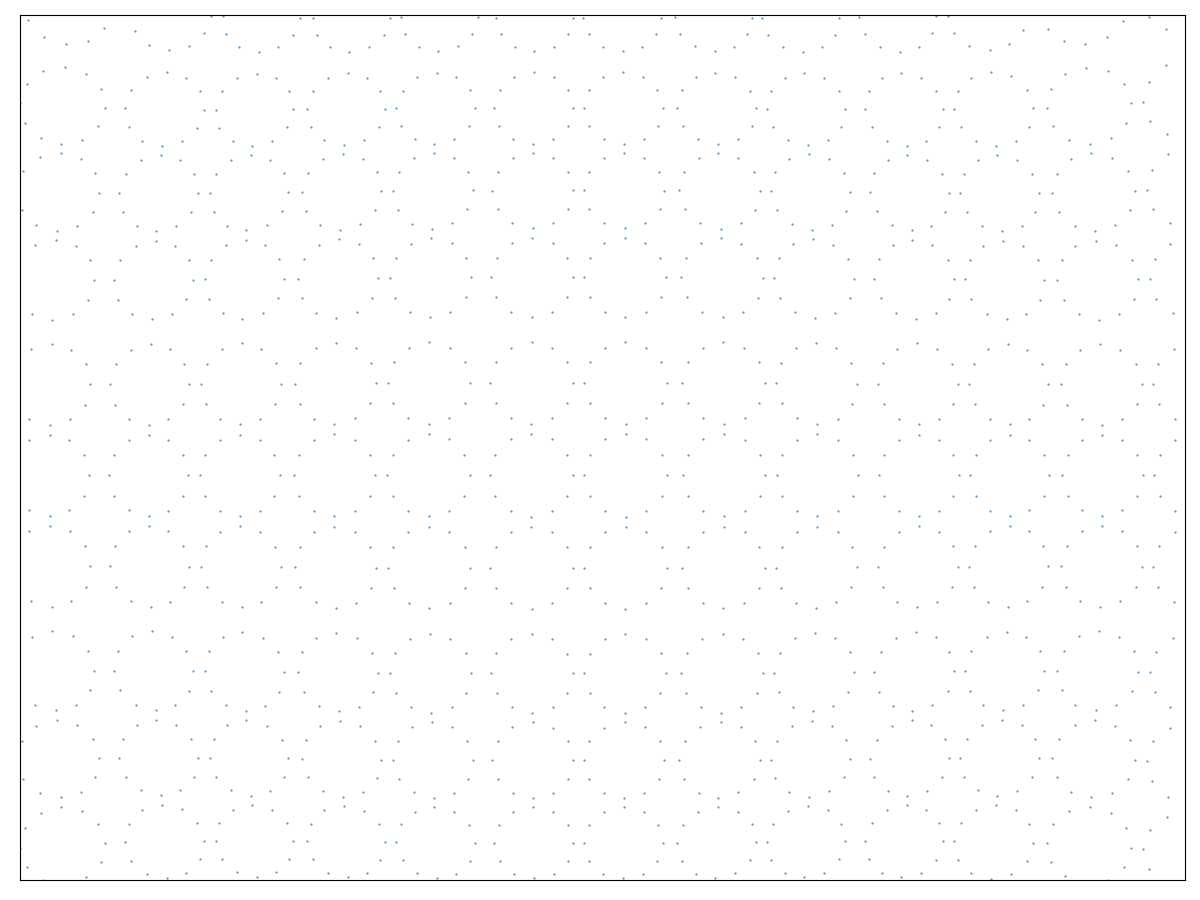

<IPython.core.display.Javascript object>


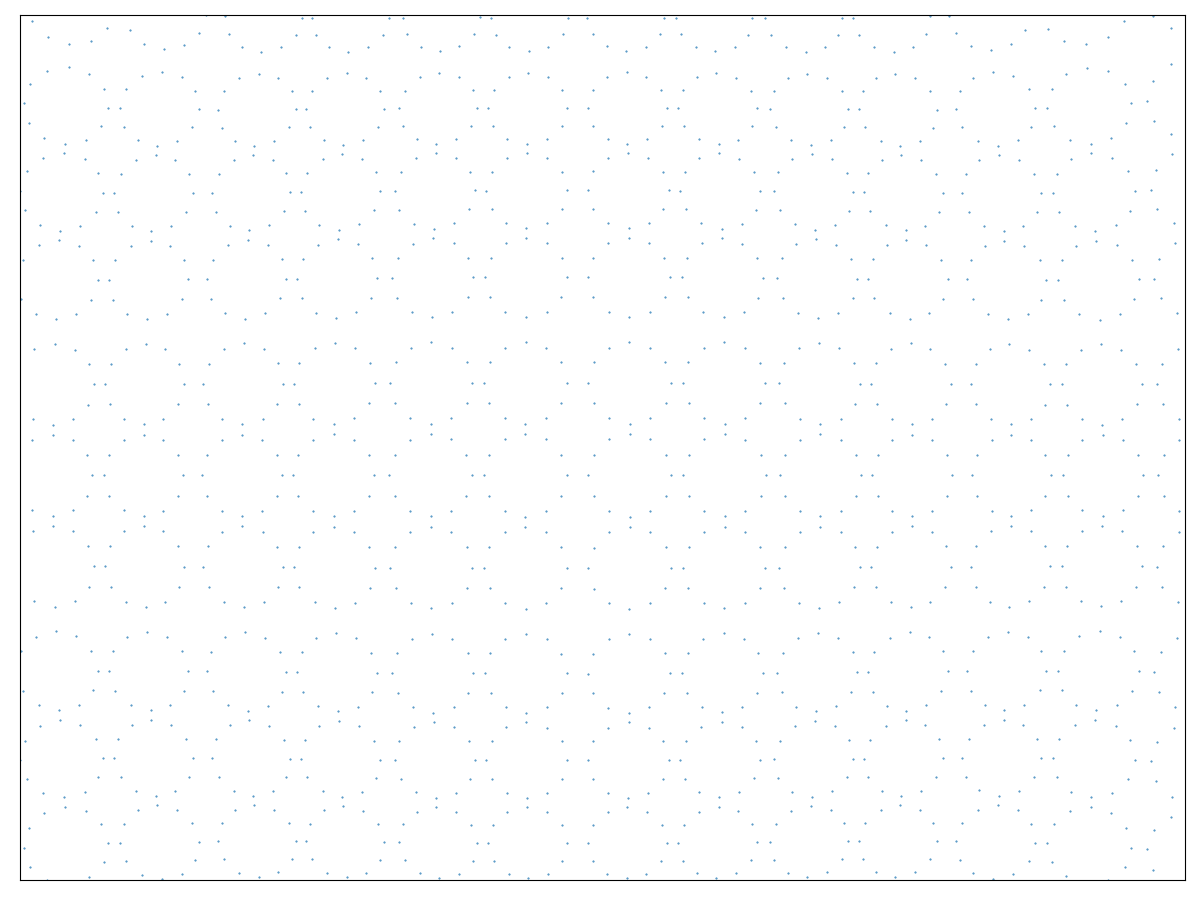

<IPython.core.display.Javascript object>


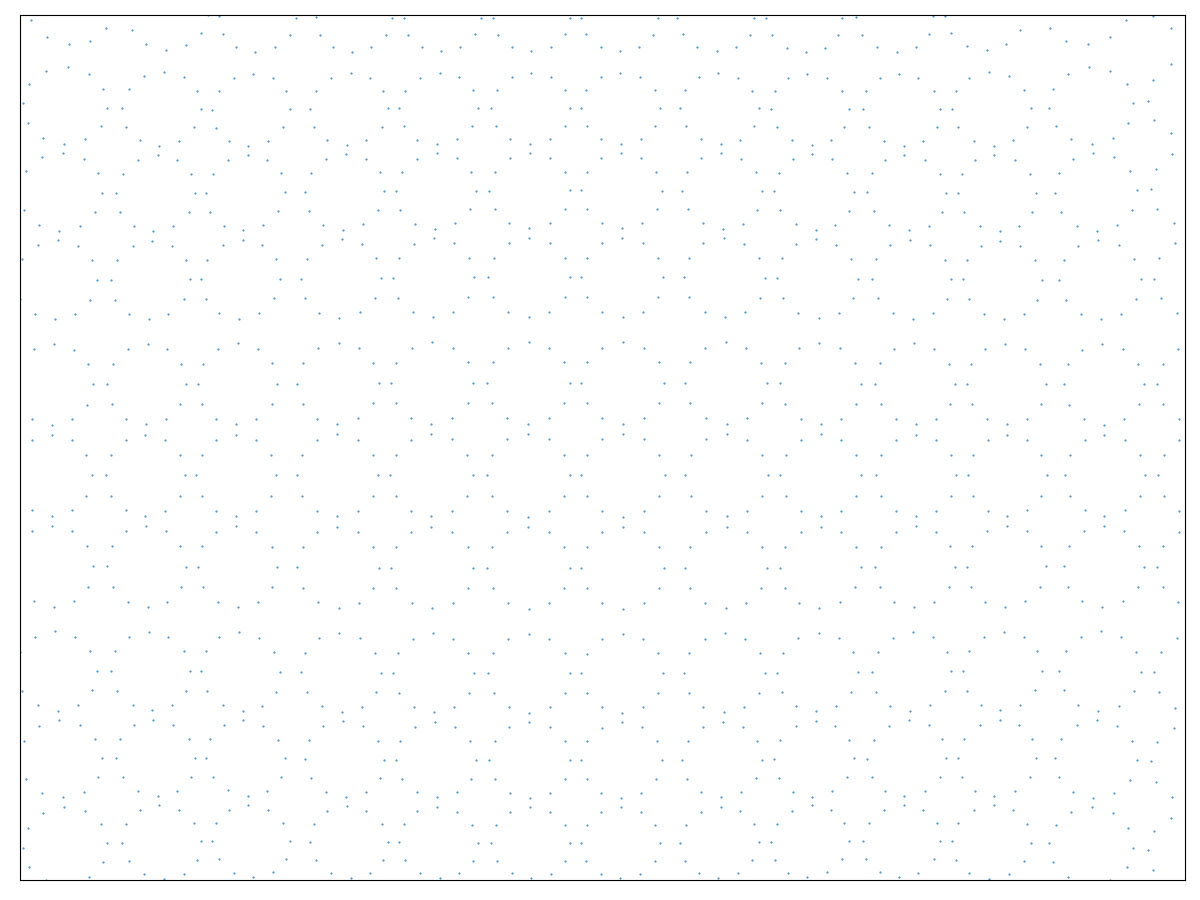

<IPython.core.display.Javascript object>


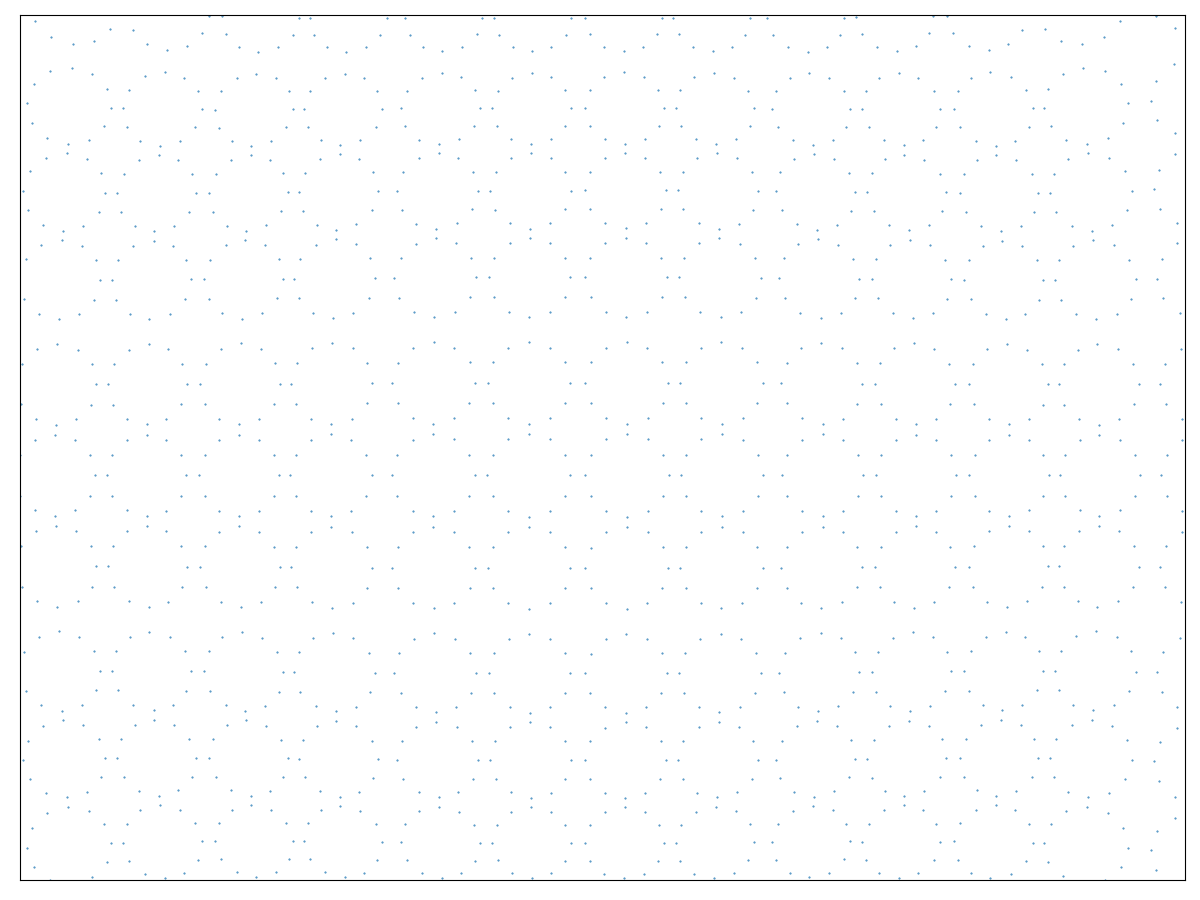

<IPython.core.display.Javascript object>


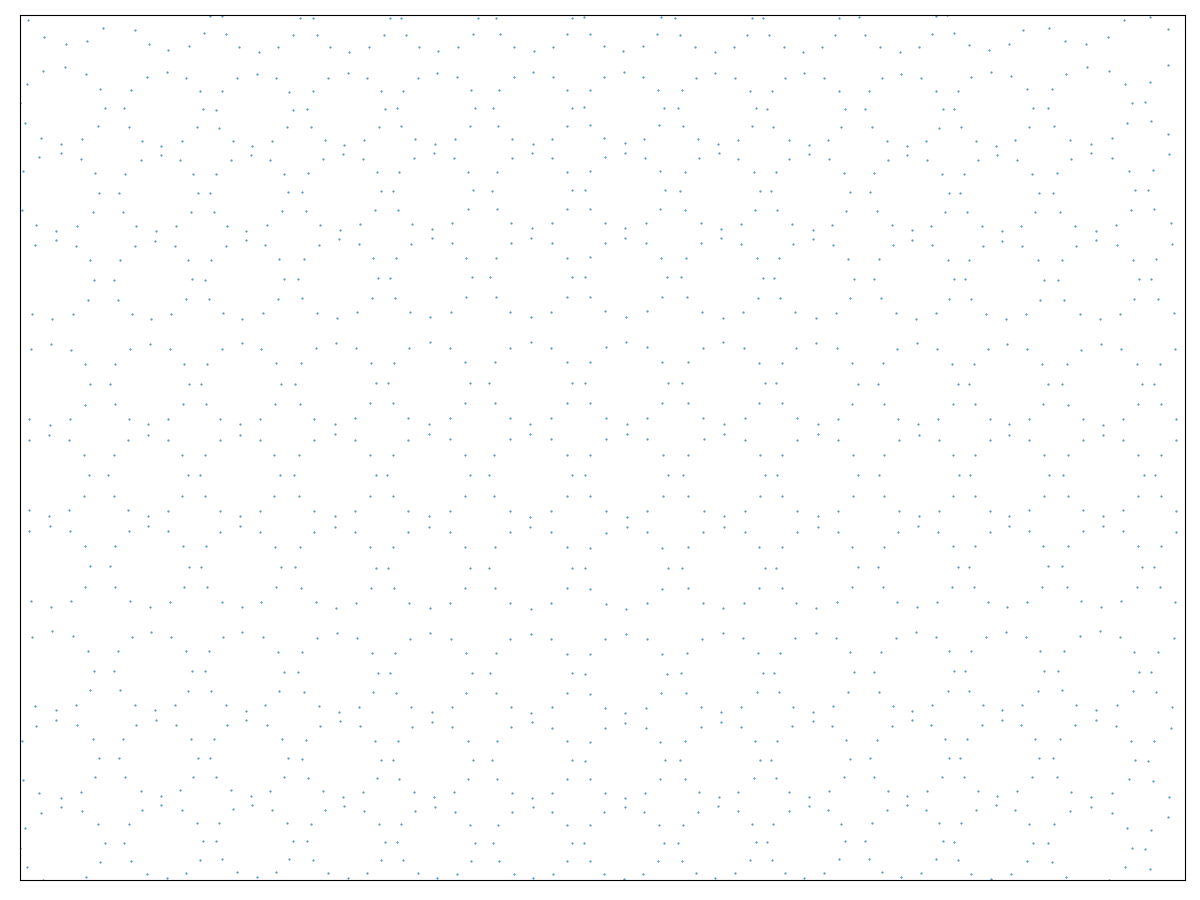

<IPython.core.display.Javascript object>


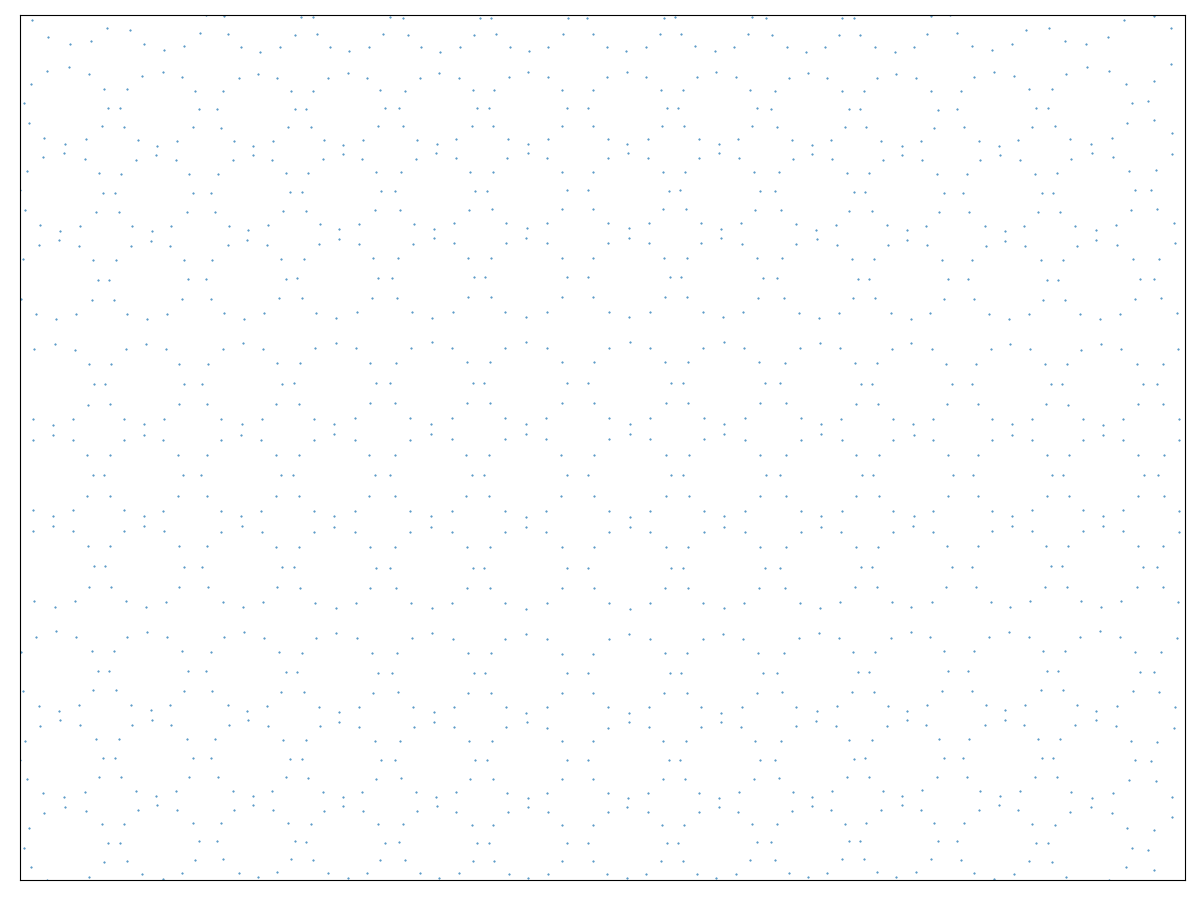

<IPython.core.display.Javascript object>


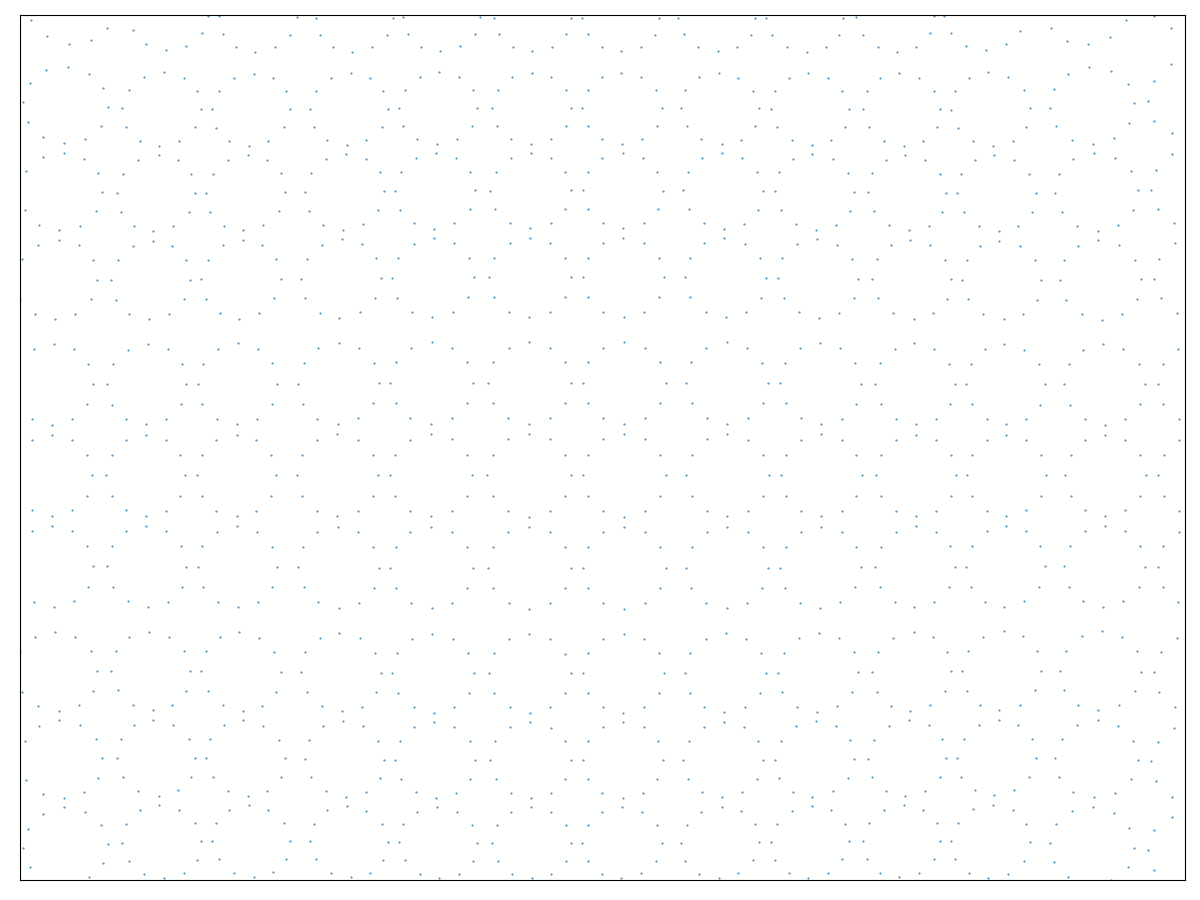

<IPython.core.display.Javascript object>


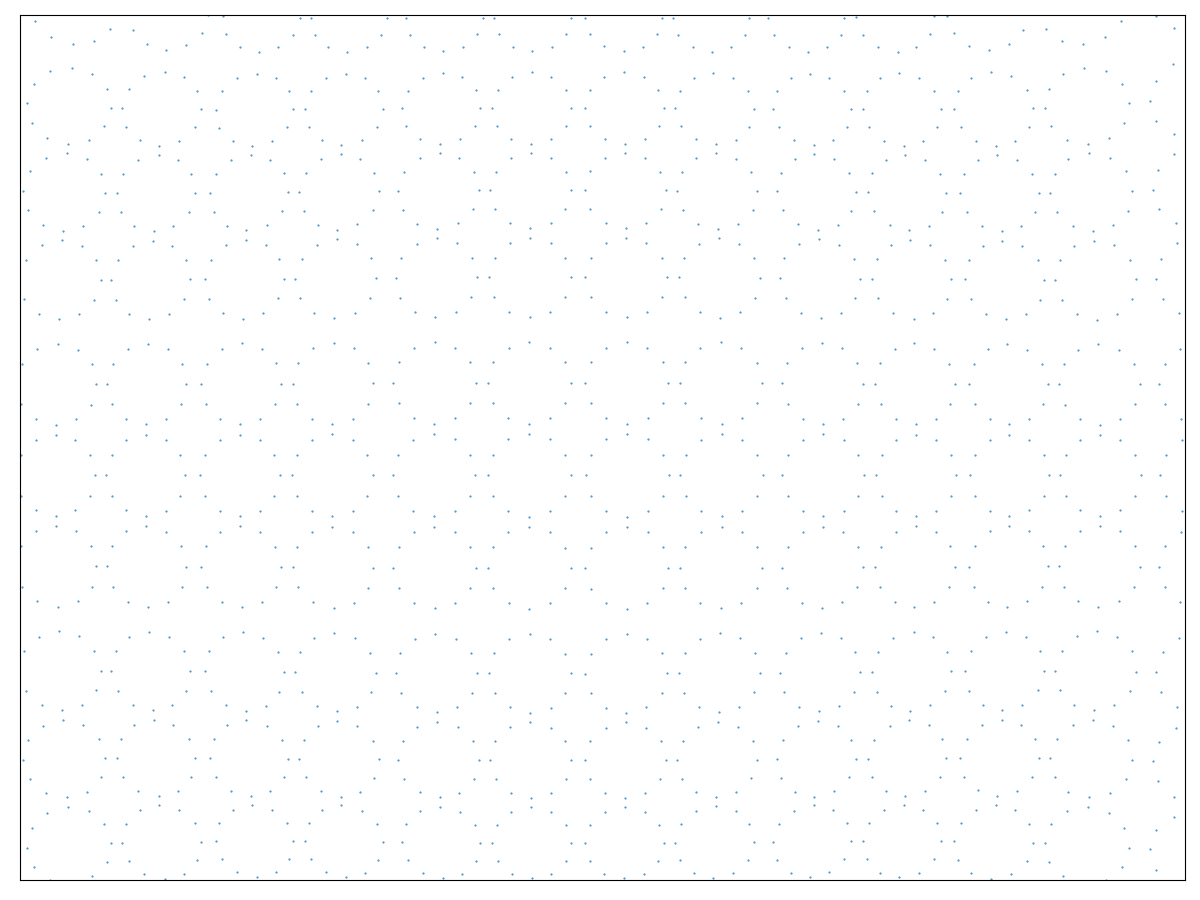

<IPython.core.display.Javascript object>


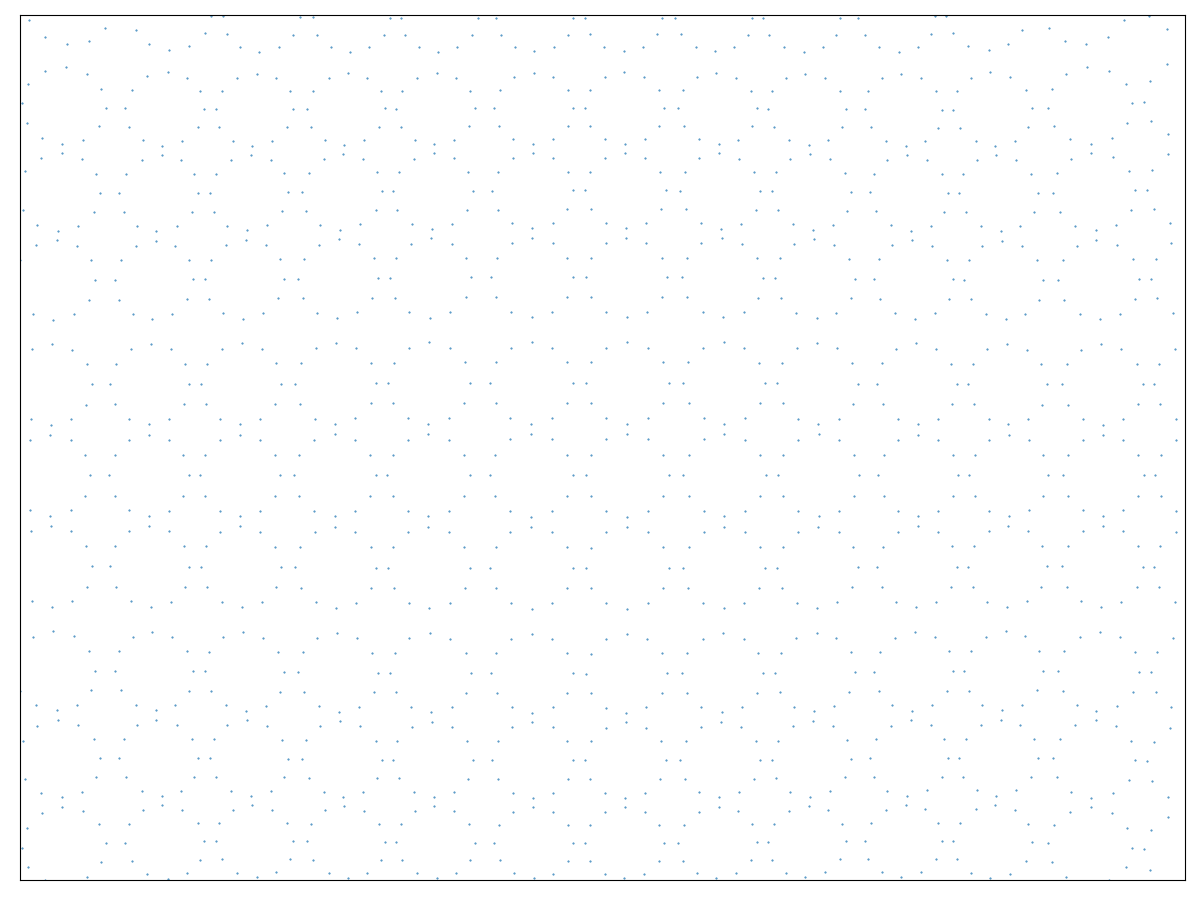

<IPython.core.display.Javascript object>


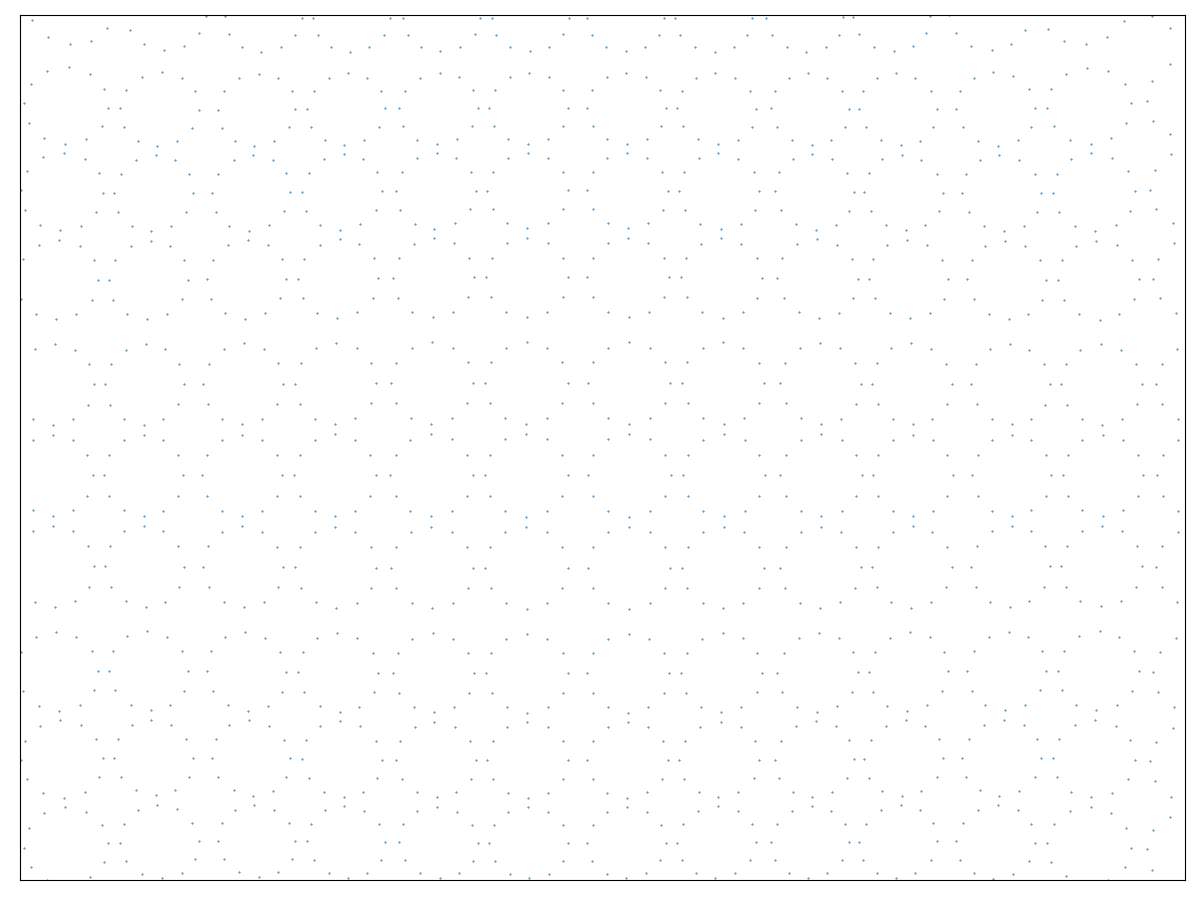

<IPython.core.display.Javascript object>


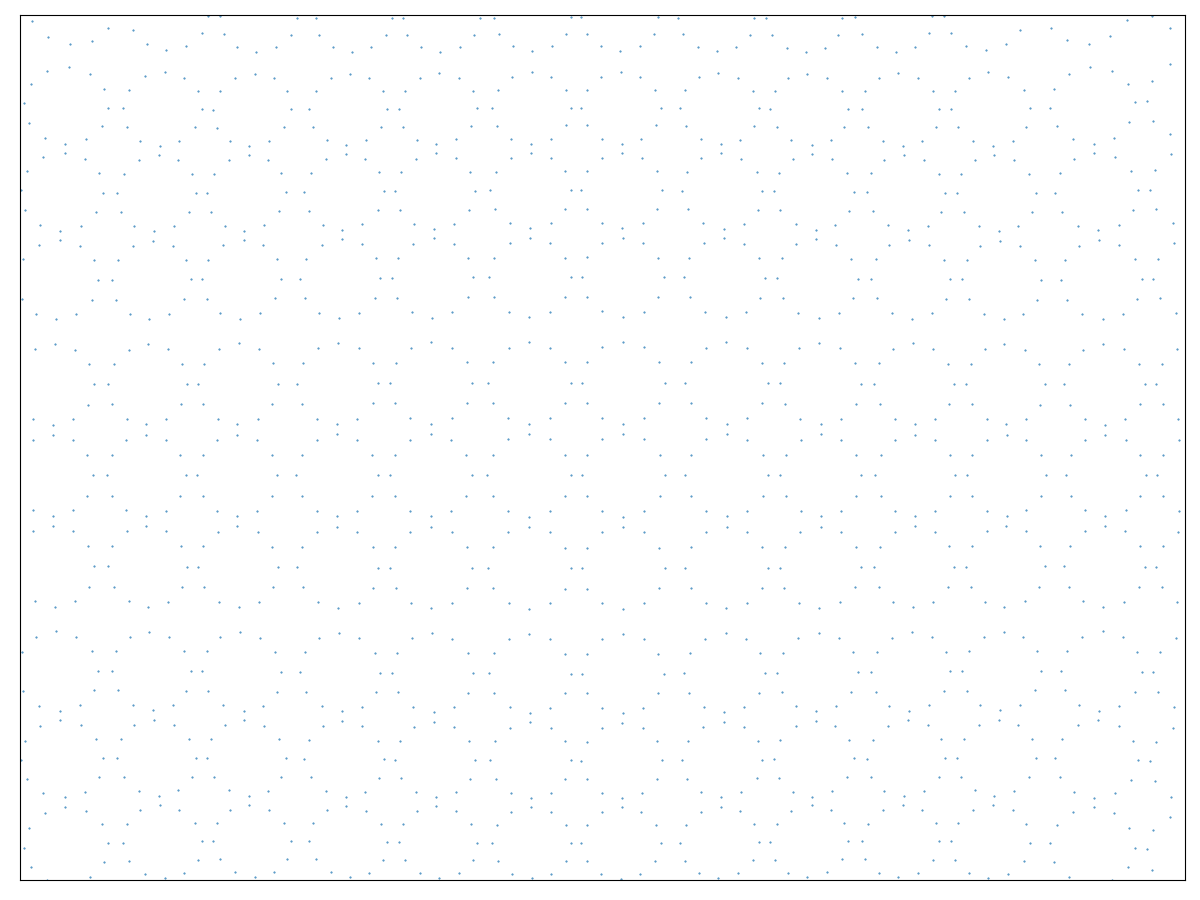

<IPython.core.display.Javascript object>


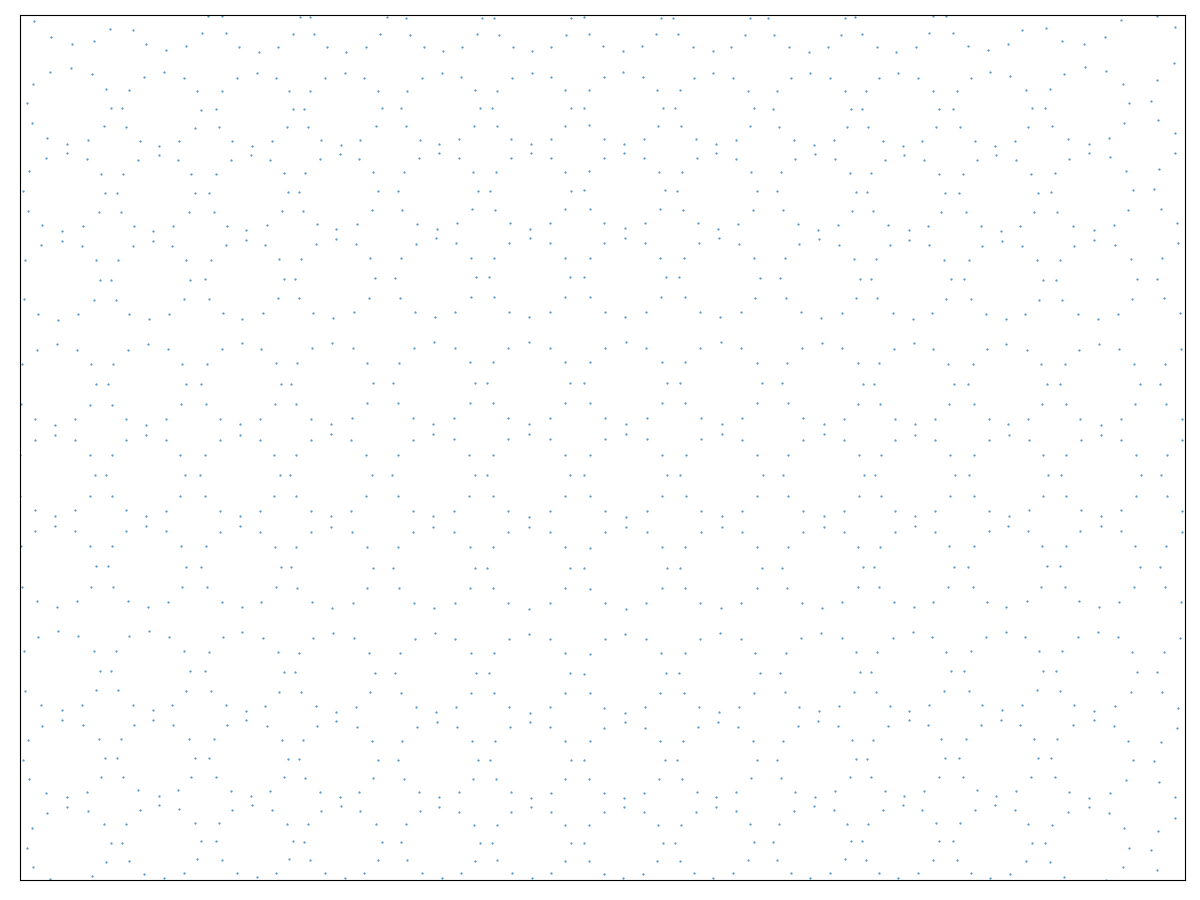

<IPython.core.display.Javascript object>


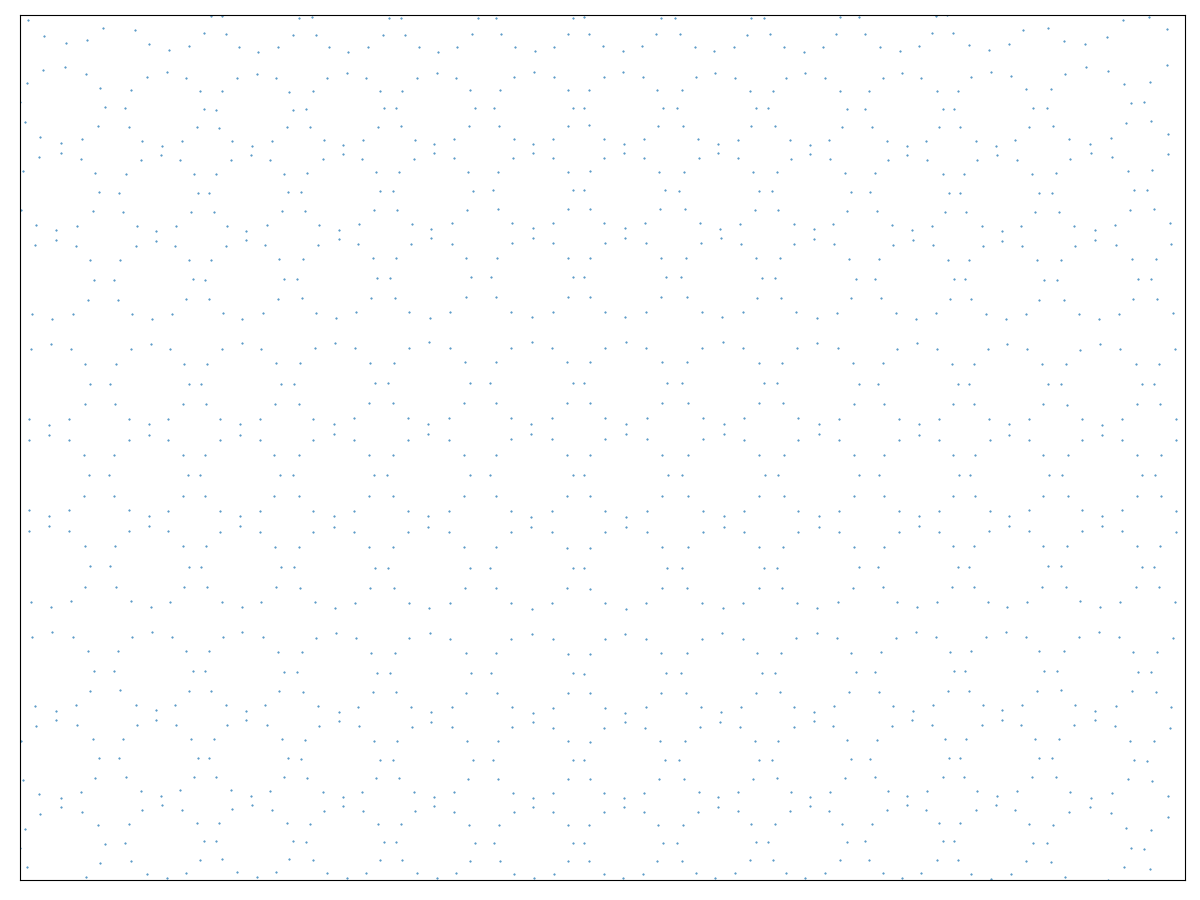

<IPython.core.display.Javascript object>


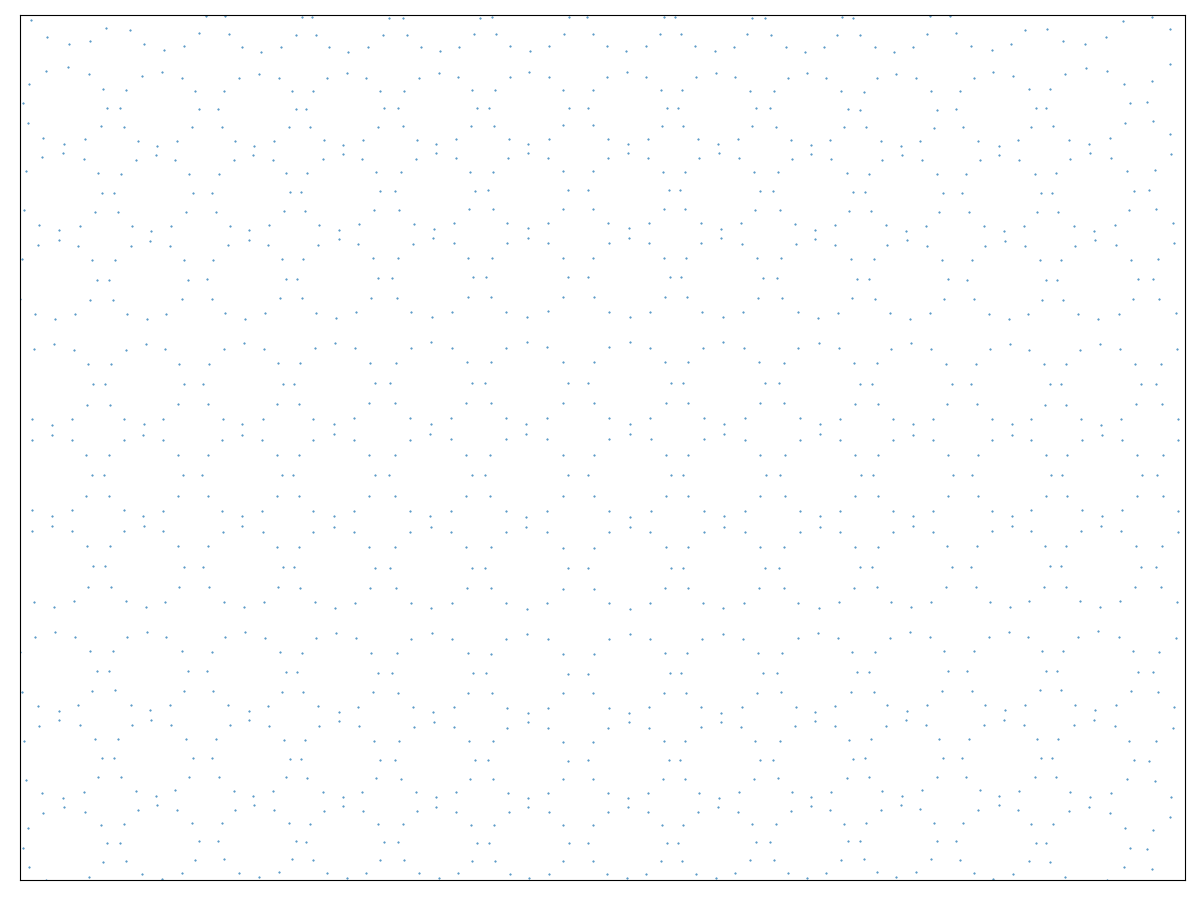

<IPython.core.display.Javascript object>


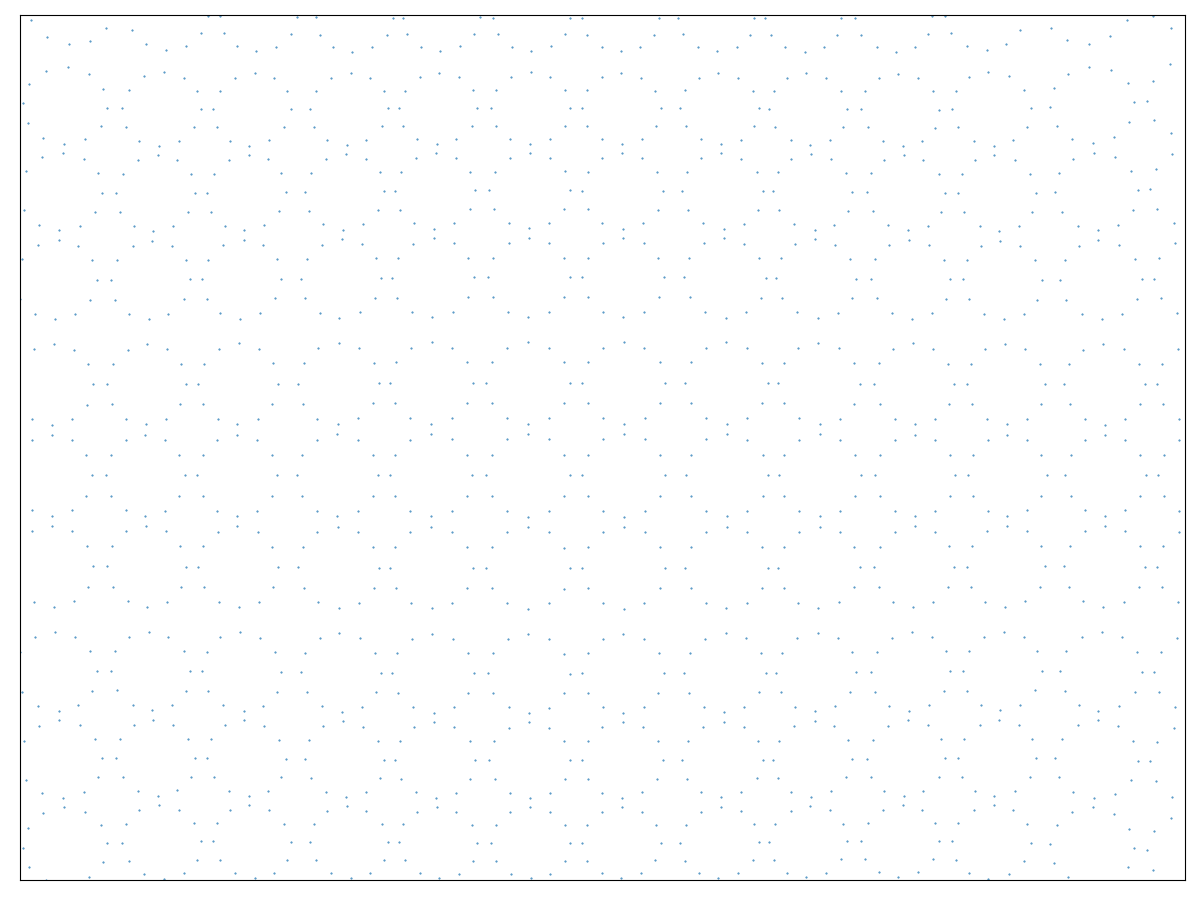

<IPython.core.display.Javascript object>


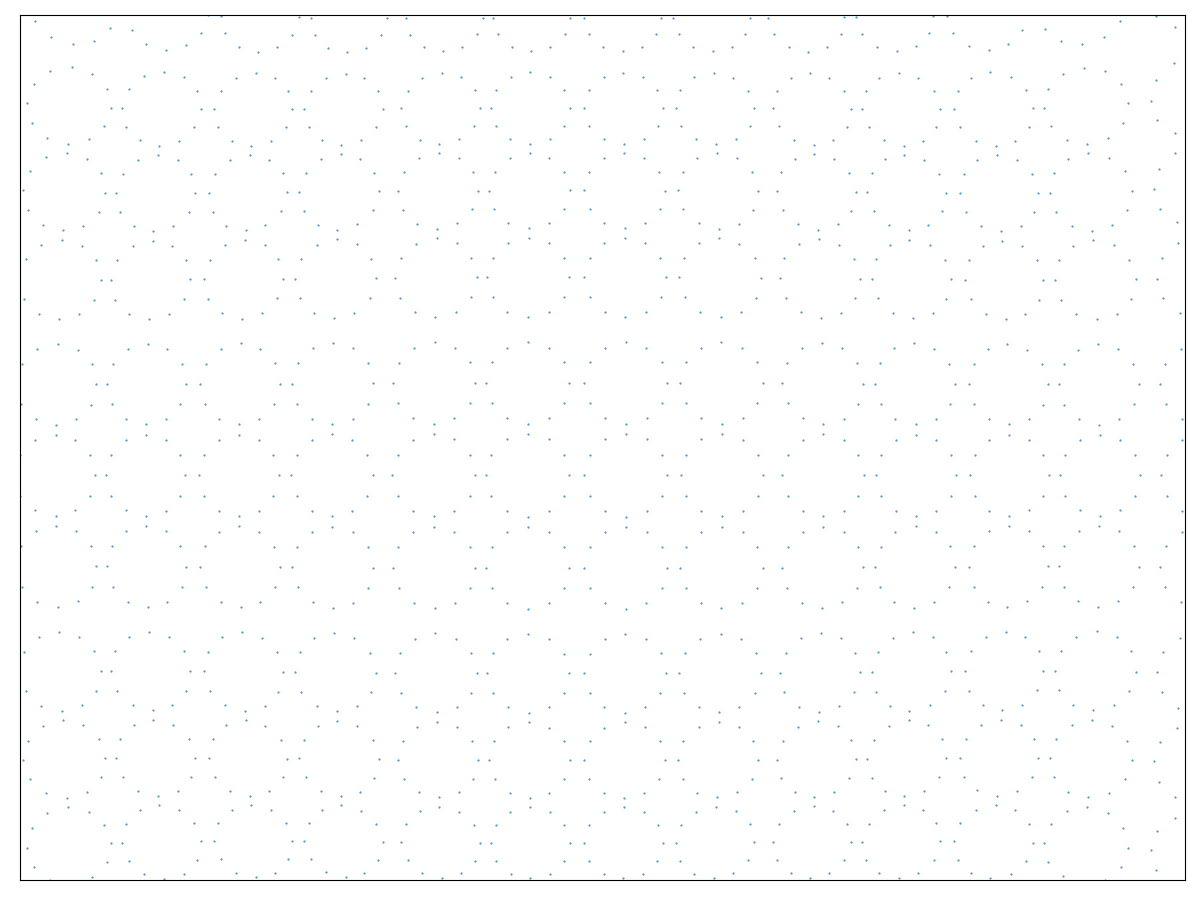

<IPython.core.display.Javascript object>


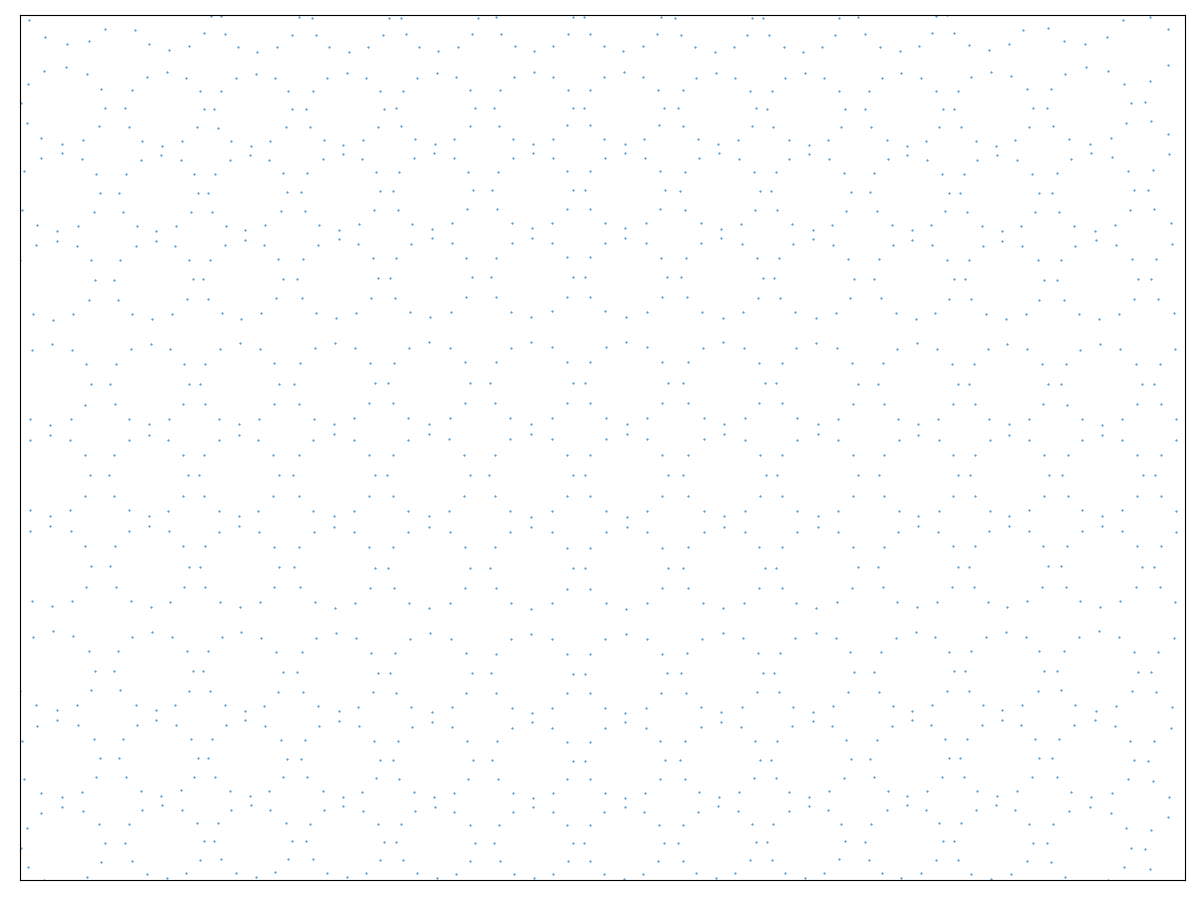

<IPython.core.display.Javascript object>


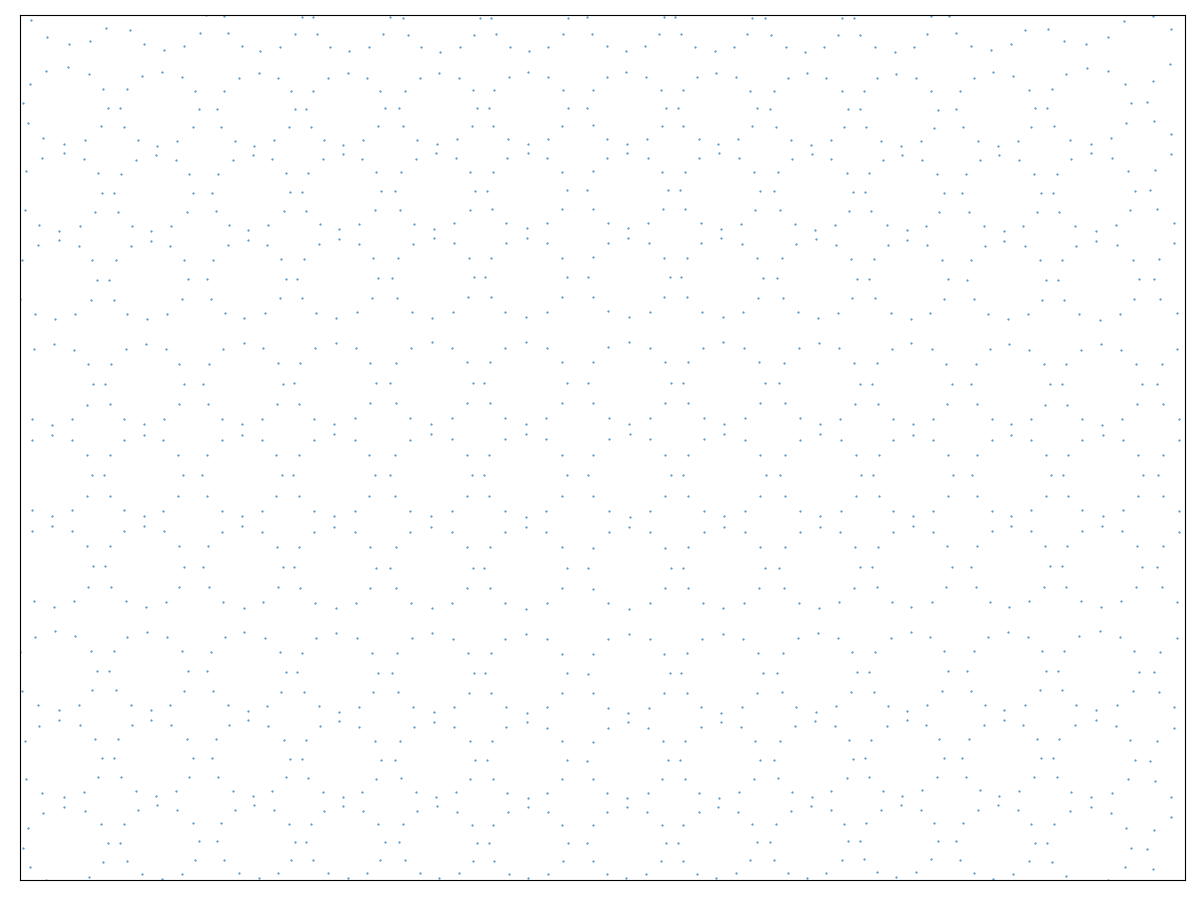

<IPython.core.display.Javascript object>


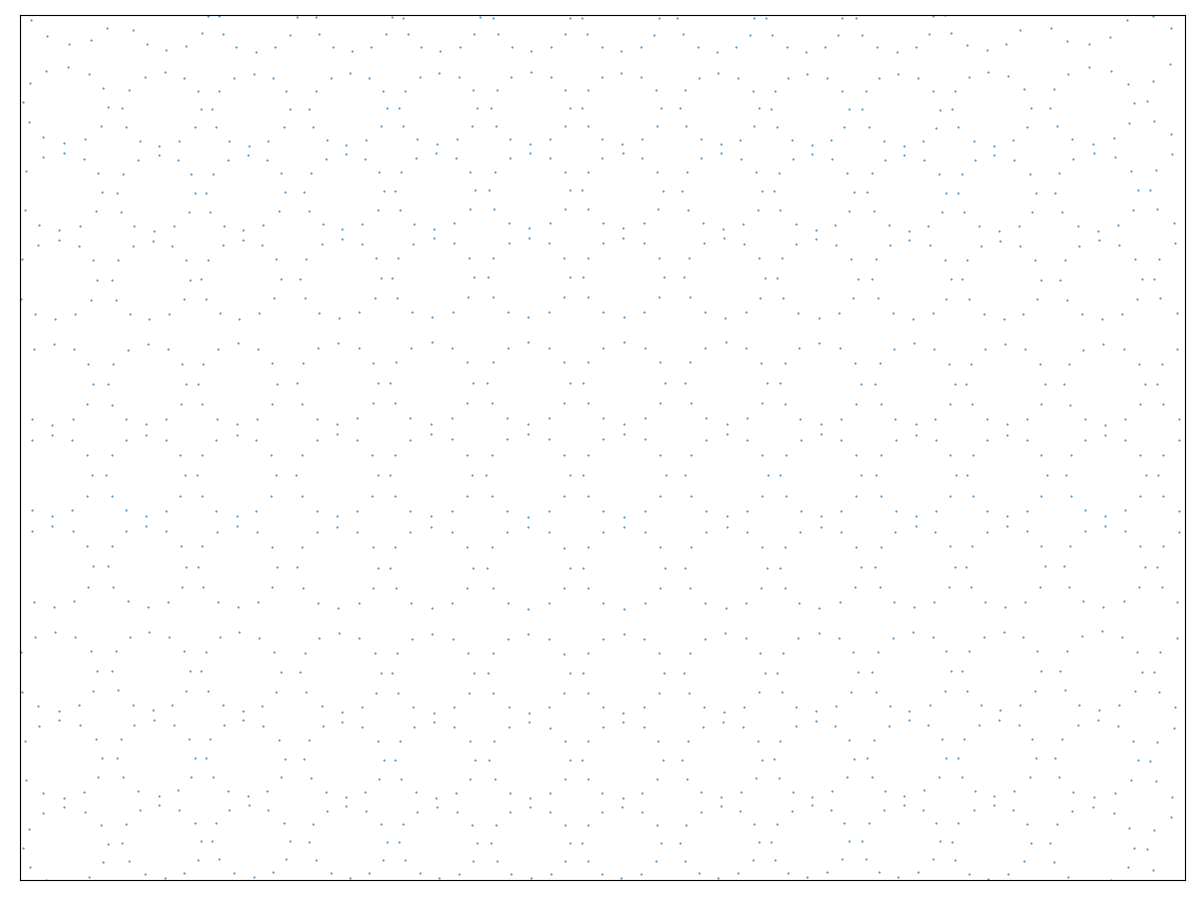

<IPython.core.display.Javascript object>


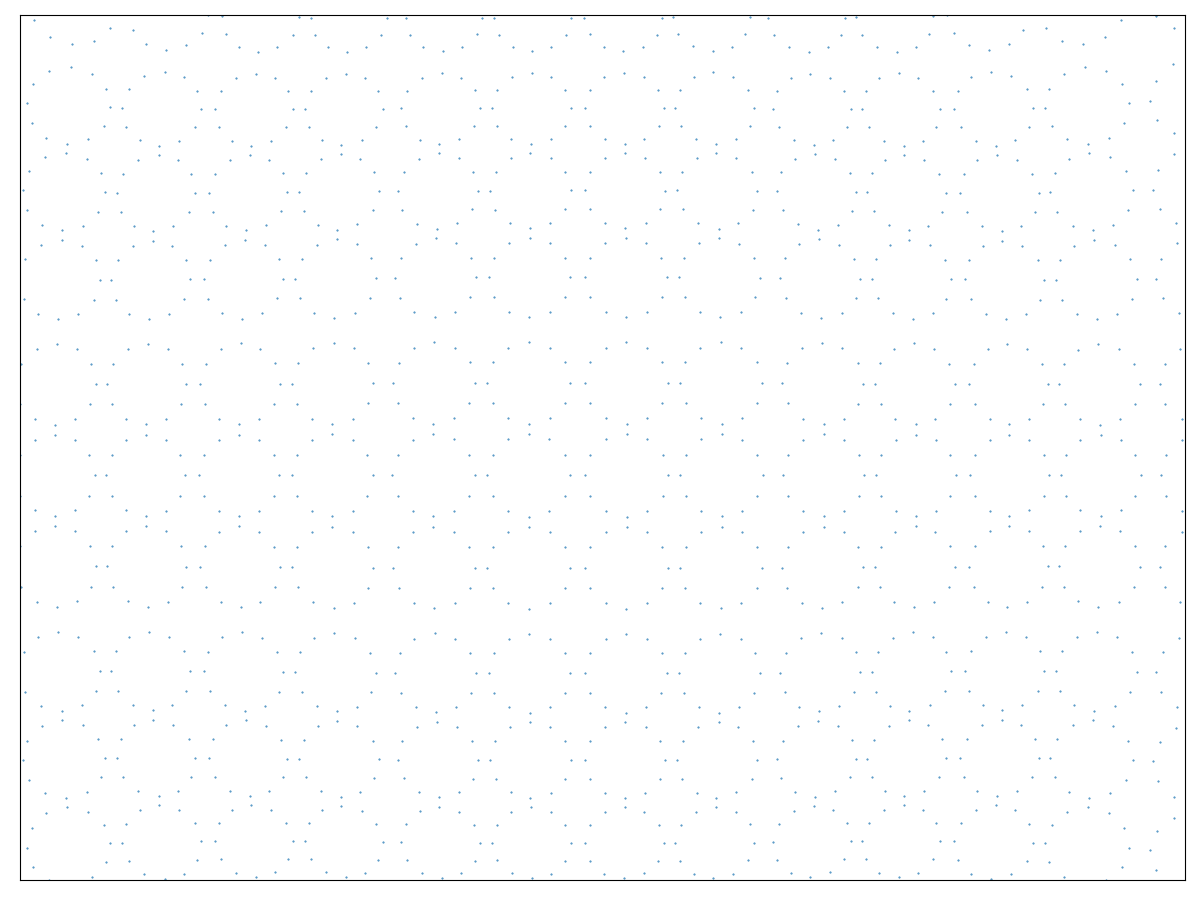

<IPython.core.display.Javascript object>


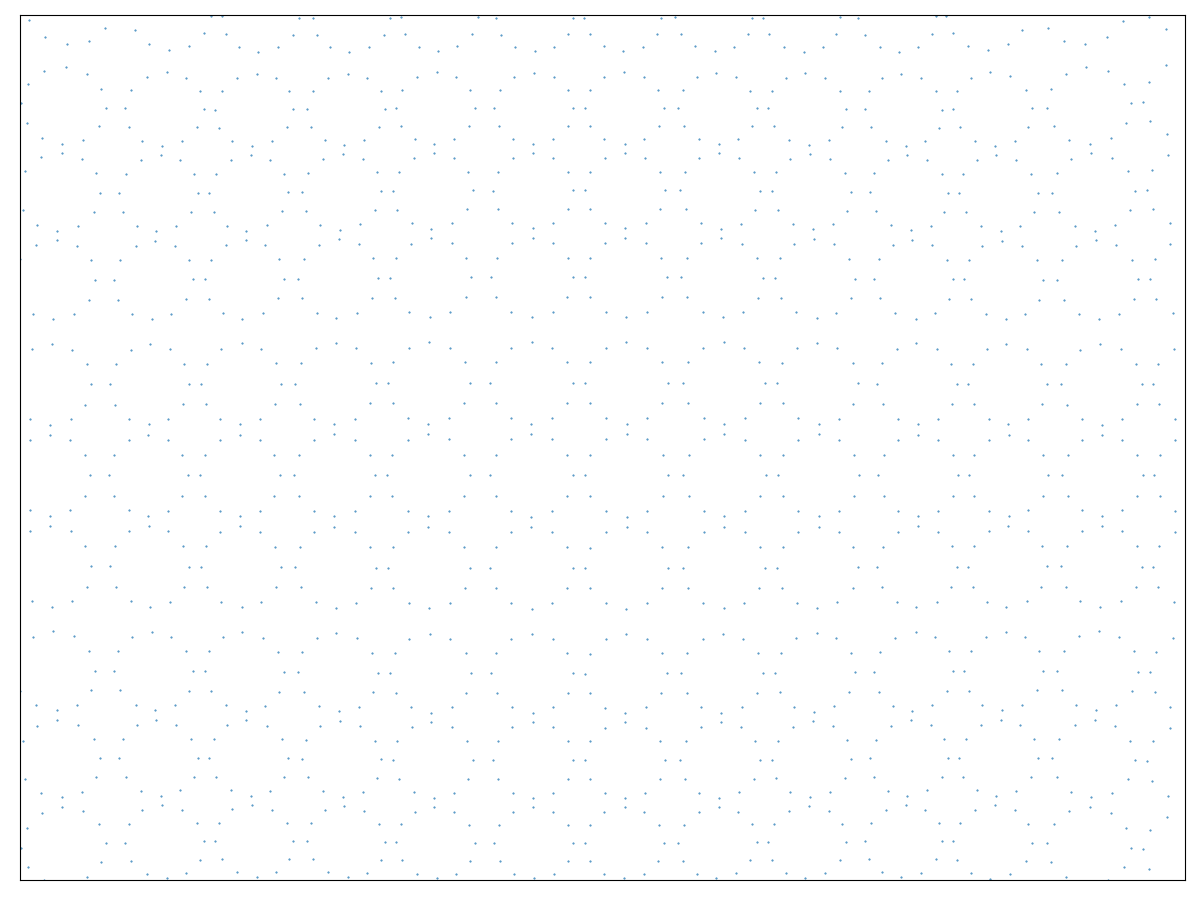

<IPython.core.display.Javascript object>


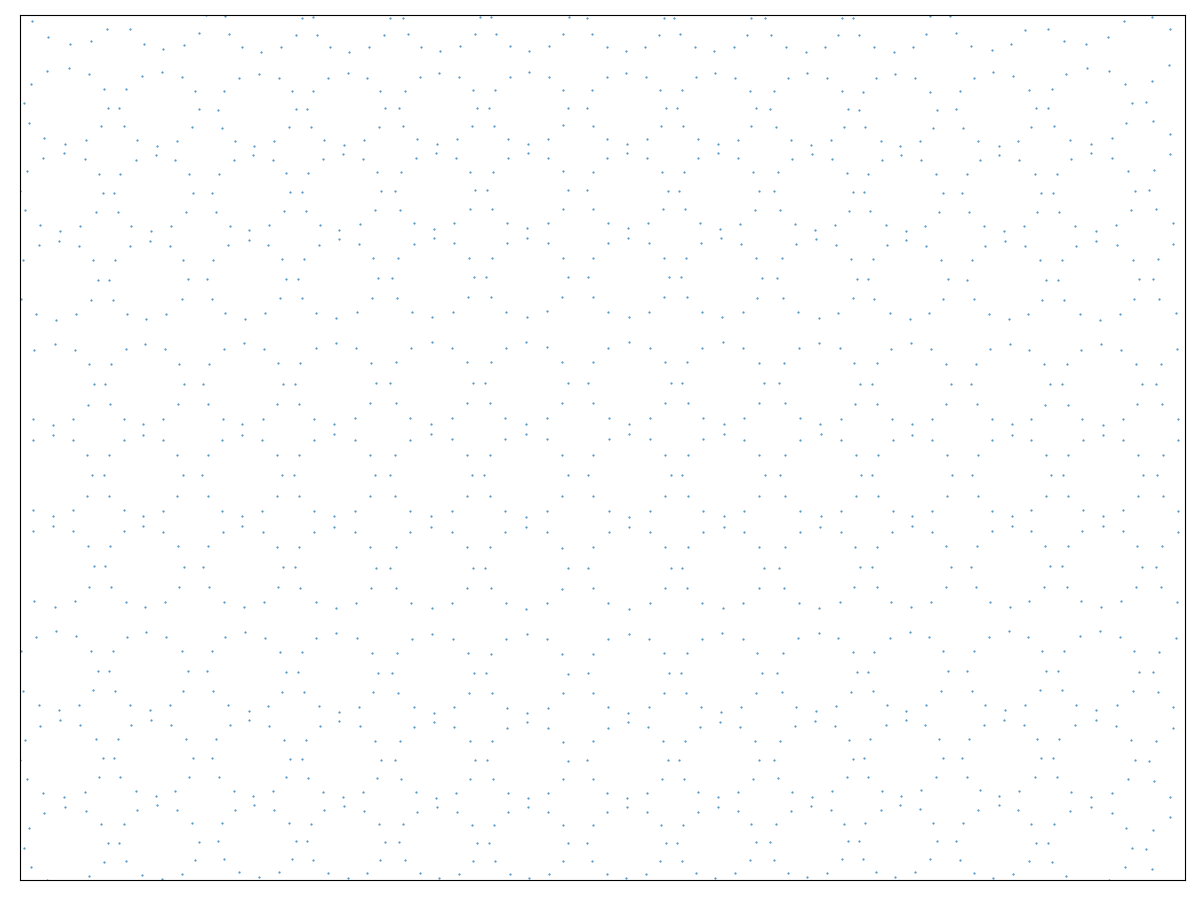

<IPython.core.display.Javascript object>


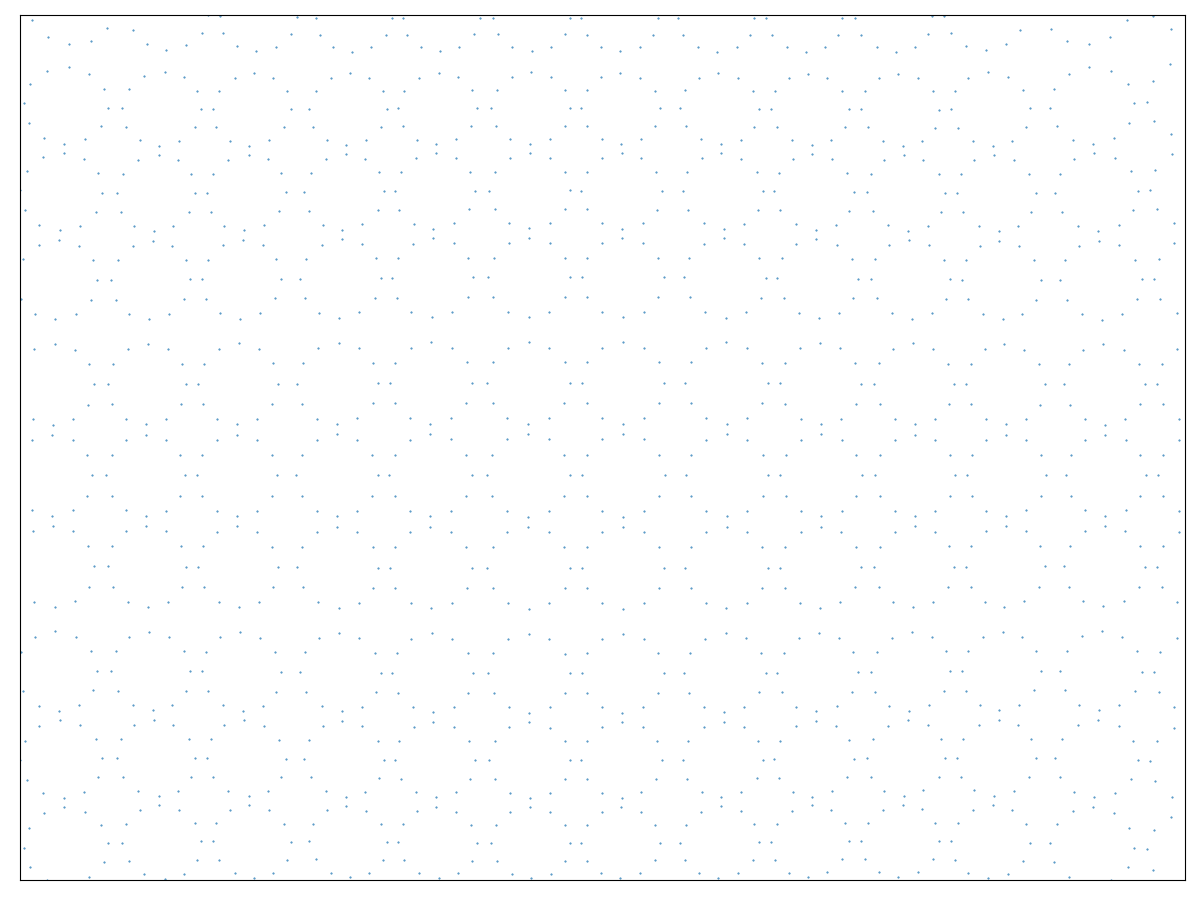

In [47]:
bolt_count = 12
bolt_positions = geo.get_bolt_locations_barrel(pmt_locations, bolt_count)
simulator = fit.PhotogrammetrySimulator(bolt_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)
image_feature_locations = simulator.get_image_feature_locations(area_restrict = [[0, 4000], [0, 3000]], min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
print("Feature in image counts:", Counter(feature_counts.values()))
simulator.show_images(image_feature_locations, area=[[0,4000],[0,3000]])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


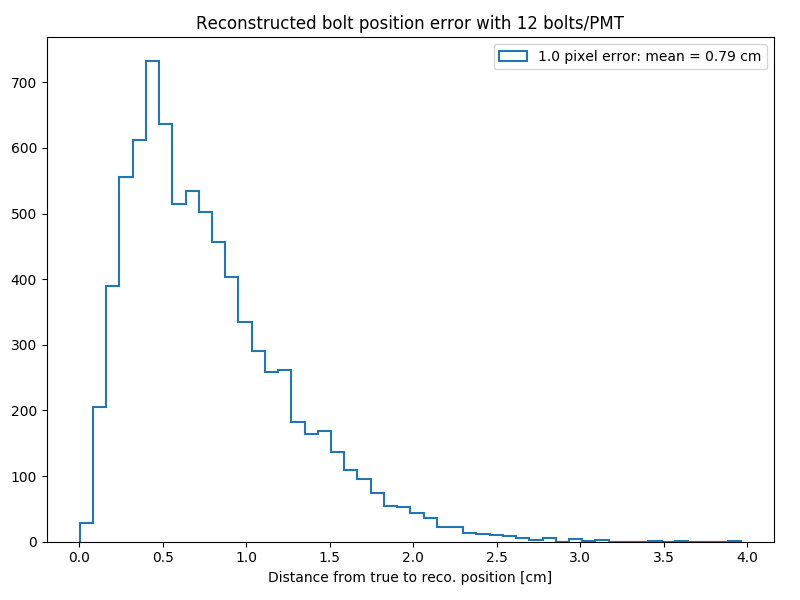

<IPython.core.display.Javascript object>


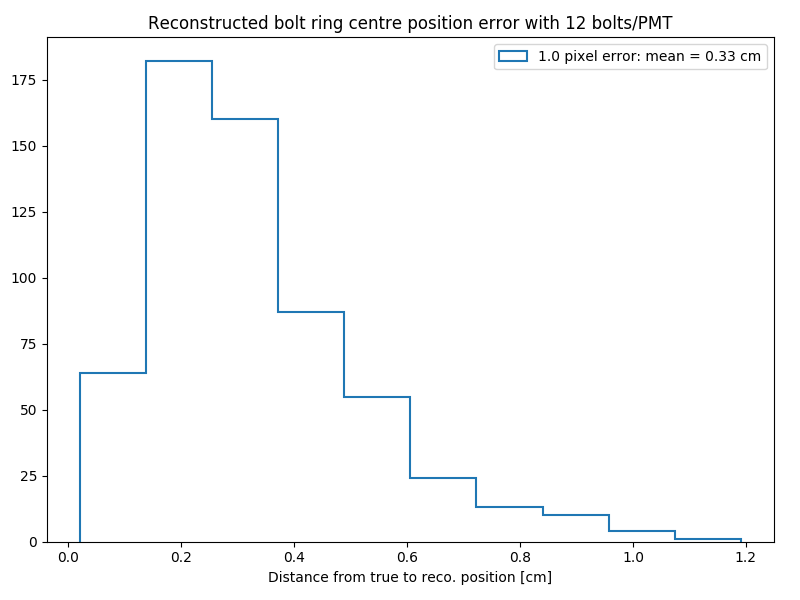

<IPython.core.display.Javascript object>


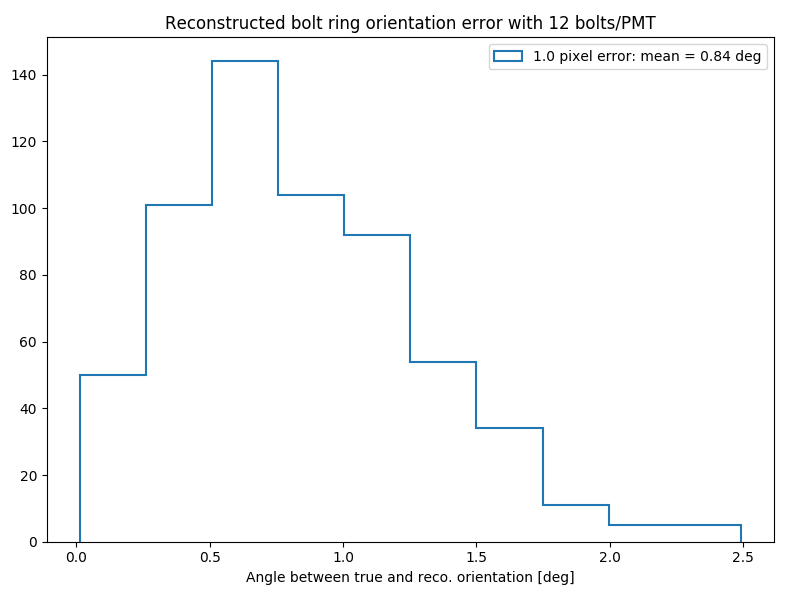

=== Gaussian errors on feature image locations: 1.0 ===
Feature in image counts: Counter({2: 7742, 3: 208})
50 images with total of  7950 features
image 0 reprojection errors:    average: 5.826827501548131    max: 14.621071496467225
image 1 reprojection errors:    average: 6.2511542869499    max: 19.717040267014667
image 2 reprojection errors:    average: 6.760778592914035    max: 18.350784924525556
image 3 reprojection errors:    average: 6.132381050754158    max: 15.528708663040588
image 4 reprojection errors:    average: 5.70317286358107    max: 15.7946581329765
image 5 reprojection errors:    average: 6.308175337137419    max: 19.97283563901218
image 6 reprojection errors:    average: 6.142090216581383    max: 17.791664472838946
image 7 reprojection errors:    average: 6.090721643278412    max: 15.750111330464575
image 8 reprojection errors:    average: 5.975538016884929    max: 17.025441145504807
image 9 reprojection errors:    average: 6.051335242236621    max: 14.848874589996111

<IPython.core.display.Javascript object>


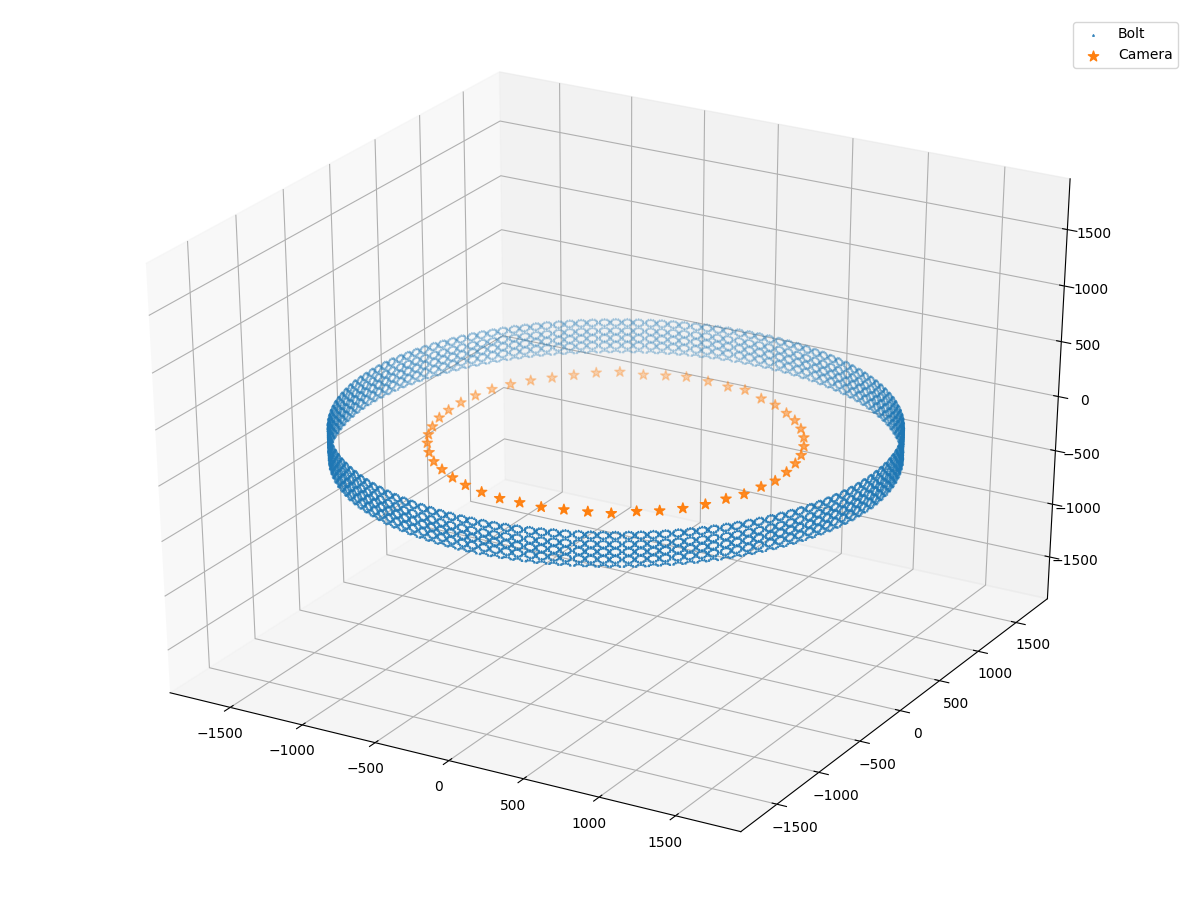

In [49]:
fig_bolt_pos, ax_bolt_pos = make_fig("Reconstructed bolt position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
fig_ring_pos, ax_ring_pos = make_fig("Reconstructed bolt ring centre position error with {} bolts/PMT".format(bolt_count), "Distance from true to reco. position [cm]")
fig_ring_ang, ax_ring_ang = make_fig("Reconstructed bolt ring orientation error with {} bolts/PMT".format(bolt_count), "Angle between true and reco. orientation [deg]")
for pixel_error in [1.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=[[1000, 3000], [750, 2250]], min_feature_count=2, pixel_error=pixel_error)
    feature_counts = Counter([f for i in smeared_feature_locations.values() for f in i.keys()])
    print("Feature in image counts:", Counter(feature_counts.values()))
    bolt_positions2 = {k: v for k, v in bolt_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_bolt_simulation(bolt_positions2, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_bolt_positions, position_errors = run_bolt_fit(fitter, bolt_positions2, xtol=1e-5)
    centre_errors = get_ring_centre_errors(reco_bolt_positions, ring_positions, bolt_count)
    orientation_errors = get_ring_orientation_errors(reco_bolt_positions, ring_orientations, bolt_count)
    ax_bolt_pos.hist(position_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors.mean()))
    ax_ring_pos.hist(centre_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors.mean()))
    ax_ring_ang.hist(orientation_errors, bins=10, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors.mean()))
    reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(bolt_positions, reco_bolt_positions)
    reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
    plot_reconstruction(reco_transformed, reco_cam_positions)
ax_bolt_pos.legend(loc='upper right')
ax_ring_pos.legend(loc='upper right')
ax_ring_ang.legend(loc='upper right')